# Prepare combined ref data for integration
Prepare a smaller data subset for integaryion in order to test out different integratiuon parameters.

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ann
import pickle
from scipy import sparse
import scIB as scib

import seaborn as sb
from matplotlib import rcParams
import matplotlib.pyplot as plt
from venn import venn

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
import helper as h
from constants import SAVE

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import anndata2ri
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R
library(scran)
library(BiocParallel)

In [6]:
#Path for saving results
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/ref_combined/preprocessed/'
#Unique ID2 for reading/writing h5ad files with helper function
UID2='combined_ref'

In [5]:
# List of datasets informations: (study_name, path)
data=[('Fltp_P16','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/'),
      ('Fltp_adult','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/'),
      ('Fltp_2y','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/'),
      ('VSG','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/ref/'),
      ('STZ','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/ref/')]

## Load data

In [ ]:
# Load data from individual studies, using raw counts and adding additional metadata
adatas=[]
for study,path in data:
    print(study)
    #Load data
    adata=h.open_h5ad(file=path+'data_annotated.h5ad',unique_id2=UID2).raw.to_adata()
    print(adata.shape)
    metadata=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
                          sheet_name=study)
    # Add metadata 
    samples=adata.obs.file.unique()
    for col in ['sex','age','design','strain','tissue','technique']:
        #Do not add metadata that is already in adata - otherwise sex would be overwritten where it was annotated
        if col in metadata.columns and col not in adata.obs.columns:
            value_map={sample:metadata.query('sample_name =="'+sample+'"')[col].values[0] for sample in samples}
            adata.obs[col]=adata.obs.file.map(value_map)
            
    adatas.append(adata)
    
# Combine datasets    
adata = ann.AnnData.concatenate( *adatas,  batch_key = 'temp_batch', batch_categories = [d[0] for d in data ]).copy()

In [25]:
# Rename index of studies that have single sample and do not contain sample info (STZ)
index=[]
for idx,row in adata.obs.iterrows():
    if '-'+row['file']+'-'+row['study'] in idx:
        index.append(idx)
    else:
        index.append(idx.replace('-'+row['study'],'-'+row['file']+'-'+row['study']))

adata.obs_names=index
if adata.raw is not None:
    adata_raw=adata.raw.to_adata()
    adata_raw.obs_names=index
    adata.raw=adata_raw
    del adata_raw

In [7]:
#Retain only relevant obs columns
adata.obs=adata.obs[['file', 'n_counts', 'n_genes', 'mt_frac', 'doublet_score', 'size_factors',
           'pre_cell_type', 'cell_type','cell_type_multiplet',
           'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 
           'x_score', 'y_score', 'sex', 
           'age', 'design', 'strain', 'tissue', 'technique', 'study']]

#Rename per study size factors
adata.obs.rename(columns={'size_factors':'size_factors_study'}, inplace=True)

# Remove obsm
del adata.obsm

In [8]:
# Add merged column for study and sample: study_sample
adata.obs['study_sample']=[study+'_'+sample for study, sample in zip(adata.obs.study,adata.obs.file)]

In [9]:
adata

AnnData object with n_obs × n_vars = 73487 × 13674
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'doublet_score', 'size_factors_study', 'pre_cell_type', 'cell_type', 'cell_type_multiplet', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'x_score', 'y_score', 'sex', 'age', 'design', 'strain', 'tissue', 'technique', 'study', 'study_sample'
    var: 'n_cells-Fltp_2y', 'n_cells-Fltp_P16', 'n_cells-Fltp_adult', 'n_cells-STZ', 'n_cells-VSG'

List cell types to decide if they need to be unified

In [65]:
# Check if cell types need to be unified
adata.obs.cell_type.unique()

array(['alpha', 'gamma', 'alpha_delta', 'beta', 'delta', 'NA',
       'alpha_proliferative', 'beta_proliferative', 'alpha_gamma',
       'beta_delta', 'alpha_delta_proliferative', 'delta_proliferative',
       'gamma_proliferative', 'alpha_delta_gamma',
       'alpha_gamma_proliferative', 'delta_gamma', 'ductal',
       'beta_delta_proliferative', 'alpha_beta_delta', 'epsilon',
       'alpha_beta_proliferative', 'immune', 'stellate', 'schwann',
       'pericyte', 'endothelial_pericyte', 'endothelial',
       'stellate_pericyte', 'acinar', 'acinar_low', 'beta_gamma',
       'beta_gamma_proliferative', 'alpha_delta_gamma_proliferative',
       'NA_proliferative', 'alpha_beta_delta_proliferative',
       'beta_delta_gamma', 'ductal_proliferative', 'alpha_beta',
       'alpha_beta_gamma', 'alpha_beta_delta_gamma',
       'beta_subpopulation_STZref', 'beta_ins_low'], dtype=object)

## Ambient genes

In [66]:
# Merge all ambient scores - from DFs of top ambient genes of individual studies
ambient_df=[]
for study,path in data:
    ambient_study=pd.read_table(path+"ambient_genes_topN_scores.tsv",index_col=0).drop('mean_ambient_n_counts',axis=1)
    ambient_study.columns=[col.replace('mean_ambient_n_counts',study) for col in ambient_study.columns]
    ambient_df.append(ambient_study)
ambient_df=pd.concat(ambient_df, axis=1)

In [67]:
# Add median ambeint score for sorting
ambient_df['median']=ambient_df.median(axis=1)
ambient_df.sort_values('median',ascending=False,inplace=True)

<AxesSubplot:>

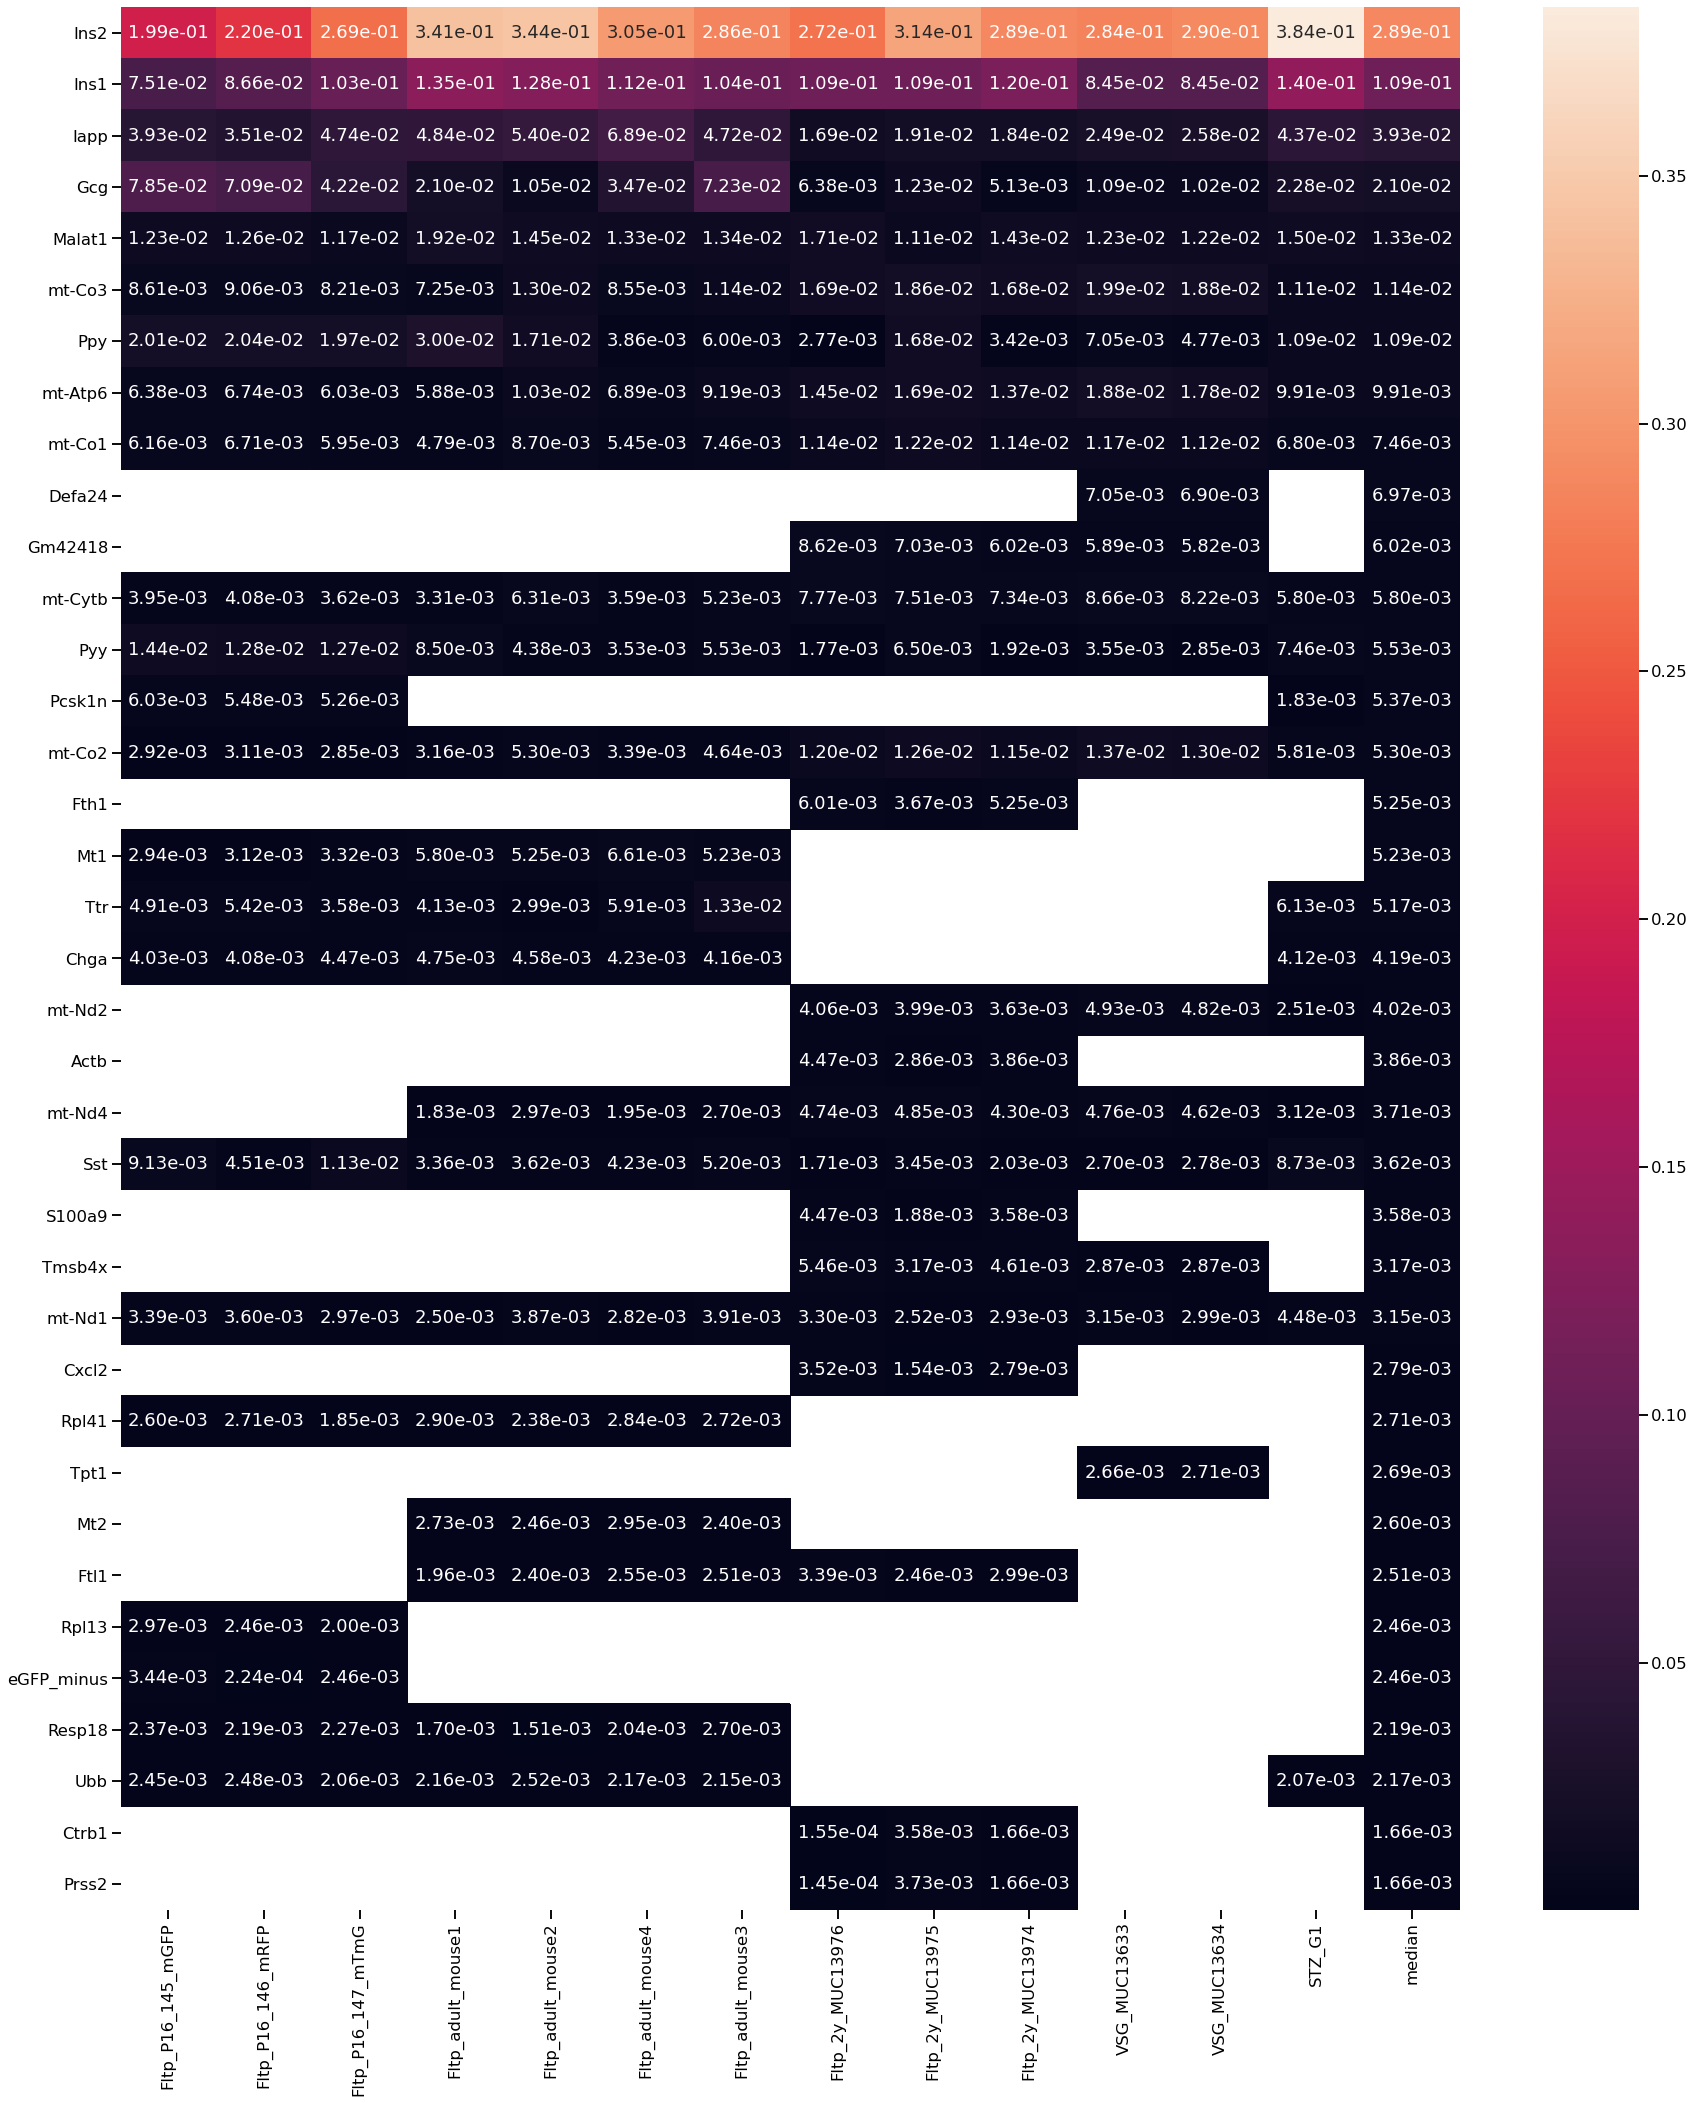

In [78]:
rcParams['figure.figsize']= (30,35)
sb.heatmap(ambient_df,annot=True,fmt='.2e')

In [69]:
# Save genes with scaled mean ambient expression at least > 0.004 in any sample 
# (this still includes last gene ambient across studies) - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
ambient_genes_selection=list(ambient_df[(ambient_df>0.004).any(axis=1)].index)

print('Selected ambient genes:',ambient_genes_selection)
pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection.pkl", "wb" ) )

Selected ambient genes: ['Ins2', 'Ins1', 'Iapp', 'Gcg', 'Malat1', 'mt-Co3', 'Ppy', 'mt-Atp6', 'mt-Co1', 'Defa24', 'Gm42418', 'mt-Cytb', 'Pyy', 'Pcsk1n', 'mt-Co2', 'Fth1', 'Mt1', 'Ttr', 'Chga', 'mt-Nd2', 'Actb', 'mt-Nd4', 'Sst', 'S100a9', 'Tmsb4x', 'mt-Nd1']


In [70]:
# Remove ambient genes from analysis 
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes=pickle.load( open( shared_folder+"ambient_genes_selection.pkl", "rb" ) )
# Save all genes to raw
adata.raw=adata.copy()
adata = adata[:,np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 13674
Number of genes after ambient removal: 13651


### Save merged data without ambient genes

In [71]:
if SAVE:
    h.save_h5ad(adata=adata,file=shared_folder+'data_noambient.h5ad',unique_id2=UID2)

... storing 'file' as categorical
... storing 'pre_cell_type' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_multiplet' as categorical
... storing 'sex' as categorical
... storing 'age' as categorical
... storing 'design' as categorical
... storing 'strain' as categorical
... storing 'tissue' as categorical
... storing 'technique' as categorical
... storing 'study_sample' as categorical


## Normalisation and log-scaling

Remove ambient genes (move counts to raw).

Scale per sample.

In [100]:
adata=h.open_h5ad(file=shared_folder+'data_noambient.h5ad',unique_id2=UID2)

In [102]:
adata.layers['counts'] = adata.X.copy()

In [103]:
for sample, idx_sample in adata.obs.groupby(['study','file']).groups.items():
    print(sample)
    # Subset data
    adata_sub=adata[idx_sample,:].copy()
    # Faster on sparse matrices
    if not sparse.issparse(adata_sub.X): 
        adata_sub.X = sparse.csr_matrix(adata_sub.X)
    # Sort indices is necesary for conversion to R object 
    adata_sub.X.sort_indices()
    
    # Prepare clusters for scran
    adata_sub_pp=adata_sub.copy()
    sc.pp.normalize_total(adata_sub_pp, target_sum=1e6, exclude_highly_expressed=True)
    sc.pp.log1p(adata_sub_pp)
    sc.pp.pca(adata_sub_pp, n_comps=15)
    sc.pp.neighbors(adata_sub_pp)
    sc.tl.louvain(adata_sub_pp, key_added='groups', resolution=1)
    
    # Normalise
    ro.globalenv['data_mat'] = adata_sub.X.T
    ro.globalenv['input_groups'] = adata_sub_pp.obs['groups']
    size_factors = ro.r(f'calculateSumFactors(data_mat, clusters = input_groups, min.mean = 0.1, BPPARAM=MulticoreParam(workers = 8))')
    adata.obs.loc[adata_sub.obs.index,'size_factors_sample'] = size_factors

del adata_sub
del adata_sub_pp

('Fltp_2y', 'MUC13974')
('Fltp_2y', 'MUC13975')
('Fltp_2y', 'MUC13976')
('Fltp_P16', '145_mGFP')
('Fltp_P16', '146_mRFP')
('Fltp_P16', '147_mTmG')
('Fltp_adult', 'mouse1')
('Fltp_adult', 'mouse2')
('Fltp_adult', 'mouse3')
('Fltp_adult', 'mouse4')
('STZ', 'G1')
('VSG', 'MUC13633')
('VSG', 'MUC13634')


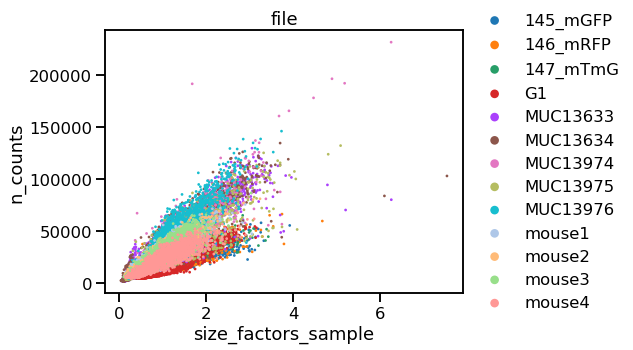

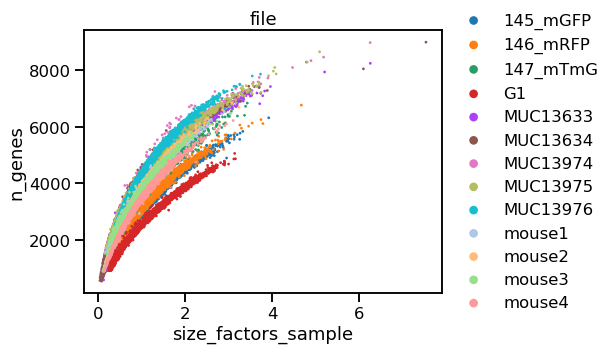

Distribution of size factors


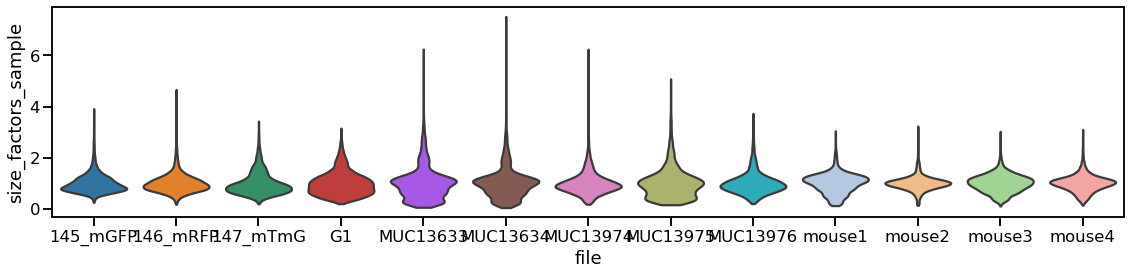

In [104]:
rcParams['figure.figsize']=(6,5)
sc.pl.scatter(adata, 'size_factors_sample', 'n_counts', color='file',size=30)
sc.pl.scatter(adata, 'size_factors_sample', 'n_genes', color='file',size=30)
rcParams['figure.figsize']=(15,4)
print('Distribution of size factors')
sc.pl.violin(adata,keys='size_factors_sample', groupby='file',stripplot=False)

In [105]:
# Scale data with size factors
adata.X /= adata.obs['size_factors_sample'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

## Highly variable genes

In [107]:
# Compute HVG across batches (samples) using scIB function
hvgs=scib.preprocessing.hvg_batch(adata, batch_key='study_sample', target_genes=2000, flavor='cell_ranger')

Using 326 HVGs from full intersect set
Using 231 HVGs from n_batch-1 set
Using 212 HVGs from n_batch-2 set
Using 252 HVGs from n_batch-3 set
Using 278 HVGs from n_batch-4 set
Using 280 HVGs from n_batch-5 set
Using 224 HVGs from n_batch-6 set
Using 197 HVGs from n_batch-7 set
Using 2000 HVGs


In [108]:
# Add HVGs to adata
hvgs=pd.DataFrame([True]*len(hvgs),index=hvgs,columns=['highly_variable'])
hvgs=hvgs.reindex(adata.var_names,copy=False)
hvgs=hvgs.fillna(False)

adata.var['highly_variable']=hvgs.values
print('Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

Number of highly variable genes: 2000


Add also a larger set of HVGs:

In [109]:
# Compute HVG across batches (samples) using scIB function
hvgs=scib.preprocessing.hvg_batch(adata, batch_key='study_sample', target_genes=5000, flavor='cell_ranger')

Using 954 HVGs from full intersect set
Using 589 HVGs from n_batch-1 set
Using 577 HVGs from n_batch-2 set
Using 556 HVGs from n_batch-3 set
Using 572 HVGs from n_batch-4 set
Using 549 HVGs from n_batch-5 set
Using 569 HVGs from n_batch-6 set
Using 630 HVGs from n_batch-7 set
Using 4 HVGs from n_batch-8 set
Using 5000 HVGs


In [110]:
# Add HVGs to adata
hvgs=pd.DataFrame([True]*len(hvgs),index=hvgs,columns=['highly_variable_5000'])
hvgs=hvgs.reindex(adata.var_names,copy=False)
hvgs=hvgs.fillna(False)

adata.var['highly_variable_5000']=hvgs.values
print('Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable_5000'])))

Number of highly variable genes: 5000


#### HVGs based on beta cells only

Subset adata to beta cells

In [11]:
[ct for ct in adata.obs.cell_type_multiplet.unique() if 'beta' in ct]

['beta',
 'beta_proliferative',
 'beta_delta',
 'beta_subpopulation_STZref',
 'beta_ins_low']

In [12]:
excluded_beta=['beta_delta']
selected_beta=[ct for ct in adata.obs.cell_type_multiplet.unique() if 'beta' in ct and ct not in excluded_beta]
selected_beta

['beta', 'beta_proliferative', 'beta_subpopulation_STZref', 'beta_ins_low']

In [14]:
# Subset adata
adata_beta=adata[adata.obs.cell_type.isin(selected_beta),:].copy()
#Filter genes:
print('Total number of genes: {:d}'.format(adata_beta.n_vars))
CELLS_THR_MIN=20
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_beta, min_cells=CELLS_THR_MIN)
print('Number of genes after beta cell filter: {:d}'.format(adata_beta.n_vars))
adata_beta.shape

Total number of genes: 13651
Number of genes after beta cell filter: 13633


(49362, 13633)

In [19]:
# Compute HVG across batches (samples) using scIB function
hvgs=scib.preprocessing.hvg_batch(adata_beta, batch_key='study_sample', target_genes=2000, flavor='cell_ranger')
# Add HVGs to adata
hvg_col='highly_variable_2000_beta'
hvgs=pd.DataFrame([True]*len(hvgs),index=hvgs,columns=[hvg_col])
hvgs=hvgs.reindex(adata.var_names,fill_value=False)
#hvgs=hvgs.fillna(False)

adata.var[hvg_col]=hvgs.values
print('Number of highly variable genes: {:d}'.format(np.sum(adata.var[hvg_col])))

Using 198 HVGs from full intersect set
Using 147 HVGs from n_batch-1 set
Using 120 HVGs from n_batch-2 set
Using 113 HVGs from n_batch-3 set
Using 152 HVGs from n_batch-4 set
Using 198 HVGs from n_batch-5 set
Using 234 HVGs from n_batch-6 set
Using 300 HVGs from n_batch-7 set
Using 387 HVGs from n_batch-8 set
Using 151 HVGs from n_batch-9 set
Using 2000 HVGs
Number of highly variable genes: 2000


#### HVGs in individual studies

In [46]:
# Compute and store HVGs per study
for study in adata.obs.study.unique():
    adata_sub=adata[adata.obs.study==study,:].copy()
    print(study,adata_sub.shape[0])
    sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
    hvg_col='highly_variable_2000_'+study
    adata.var[hvg_col]=adata_sub.var.highly_variable.reindex(adata.var_names,fill_value=False)

Fltp_P16 19881
Fltp_adult 17353
Fltp_2y 17361
VSG 11214
STZ 7678


In [47]:
# Compute and store HVGs per study for beta cells
for study in adata_beta.obs.study.unique():
    adata_sub=adata_beta[adata_beta.obs.study==study,:].copy()
    print(study,adata_sub.shape[0])
    sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
    hvg_col='highly_variable_2000_beta_'+study
    adata.var[hvg_col]=adata_sub.var.highly_variable.reindex(adata.var_names,fill_value=False)

Fltp_P16 7629
Fltp_adult 13777
Fltp_2y 14349
VSG 7822
STZ 5785


#### HVGs union across samples instead of intersection across samples

In [50]:
# Extract HVGs (ordered by normalised dispersion) from each study_sample
hvgs_lists=dict()
for study_sample in adata.obs.study_sample.unique():
    adata_sub=adata[adata.obs.study_sample==study_sample,:].copy()
    print(study_sample,adata_sub.shape[0])
    sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', n_top_genes =2000)
    hvgs_lists[study_sample]=adata_sub.var.dispersions_norm.sort_values(ascending=False).index
hvgs_lists=pd.DataFrame(hvgs_lists)
# Add next best HVG from each study_sample untill target N of HVGs is reached
hvgs=set()
for idx,row in hvgs_lists.iterrows():
    if len(hvgs) >= 2000:
        break
    hvgs.update(row.values)

Fltp_P16_145_mGFP 9221
Fltp_P16_146_mRFP 7172
Fltp_P16_147_mTmG 3488
Fltp_adult_mouse1 4094
Fltp_adult_mouse2 4664
Fltp_adult_mouse4 5359
Fltp_adult_mouse3 3236
Fltp_2y_MUC13976 6081
Fltp_2y_MUC13975 3746
Fltp_2y_MUC13974 7534
VSG_MUC13633 5486
VSG_MUC13634 5728
STZ_G1 7678


In [67]:
# Add HVGs to adata
hvg_col='highly_variable_samples_target2000'
hvgs=pd.DataFrame([True]*len(hvgs),index=hvgs,columns=[hvg_col])
hvgs=hvgs.reindex(adata.var_names,fill_value=False)
adata.var[hvg_col]=hvgs.values
print('Number of highly variable genes: {:d}'.format(np.sum(adata.var[hvg_col])))

Number of highly variable genes: 2000


In [68]:
# Same as above for beta cells

# Extract HVGs (ordered by normalised dispersion) from each study_sample
hvgs_lists=dict()
for study_sample in adata_beta.obs.study_sample.unique():
    adata_sub=adata_beta[adata_beta.obs.study_sample==study_sample,:].copy()
    print(study_sample,adata_sub.shape[0])
    sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', n_top_genes =2000)
    hvgs_lists[study_sample]=adata_sub.var.dispersions_norm.sort_values(ascending=False).index
hvgs_lists=pd.DataFrame(hvgs_lists)

# Add next best HVG from each study_sample untill target N of HVGs is reached
hvgs=set()
for idx,row in hvgs_lists.iterrows():
    if len(hvgs) >= 2000:
        break
    hvgs.update(row.values)
    
# Add HVGs to adata
hvg_col='highly_variable_samples_target2000_beta'
hvgs=pd.DataFrame([True]*len(hvgs),index=hvgs,columns=[hvg_col])
hvgs=hvgs.reindex(adata.var_names,fill_value=False)
adata.var[hvg_col]=hvgs.values
print('Number of highly variable genes: {:d}'.format(np.sum(adata.var[hvg_col])))

Fltp_P16_145_mGFP 3364
Fltp_P16_146_mRFP 2695
Fltp_P16_147_mTmG 1570
Fltp_adult_mouse1 3268
Fltp_adult_mouse2 4261
Fltp_adult_mouse4 4329
Fltp_adult_mouse3 1919
Fltp_2y_MUC13976 5481
Fltp_2y_MUC13975 2380
Fltp_2y_MUC13974 6488
VSG_MUC13633 3656
VSG_MUC13634 4166
STZ_G1 5785
Number of highly variable genes: 2003


#### HVGs at multiple resolutions

In [100]:
hvgs_lists=[]
for study_sample in adata.obs.study_sample.unique():
    level='0'
    cluster='0'
    adata_sub=adata[adata.obs.study_sample==study_sample,:].copy()
    print(study_sample,adata_sub.shape)
    sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', n_top_genes =2000)
    hvgs_lists.append(pd.Series(adata_sub.var.dispersions_norm.sort_values(ascending=False).index,
                                name=study_sample+'_l'+level+'_c'+cluster))
    adata_sub_scl=adata_sub.copy()
    sc.pp.scale(adata_sub_scl,max_value=10)
    sc.pp.pca(adata_sub_scl, n_comps=10, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata_sub_scl,n_pcs = 10) 
    sc.tl.leiden(adata_sub_scl, resolution=1, directed=True, use_weights=True)
    adata_sub.obs['leiden_scl']=adata_sub_scl.obs.leiden
    level='1'
    for cluster in adata_sub.obs.leiden_scl.unique():
        adata_sub_sub=adata_sub[adata_sub.obs.leiden_scl==cluster,:].copy()
        # Subset genes
        min_cells=10
        if adata_sub_sub.shape[0] >= min_cells:
            sc.pp.filter_genes(adata_sub_sub, min_cells=min_cells)
            print(level,cluster,adata_sub_sub.shape)
            sc.pp.highly_variable_genes(adata_sub_sub, flavor='cell_ranger', n_top_genes =2000)
            hvgs_lists.append(pd.Series(adata_sub_sub.var.dispersions_norm.sort_values(ascending=False).index,
                             name=study_sample+'_l'+level+'_c'+cluster))
        else:
            print('Cluster %s (level %s) has %i cells (less than %i) and is thus ignored'%(
                cluster,level,adata_sub_sub.shape[0],min_cells))
hvgs_lists=pd.concat(hvgs_lists,axis=1)

Fltp_P16_145_mGFP (9221, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 6 (739, 11172)
1 8 (575, 10713)
1 11 (281, 9621)
1 14 (133, 8643)
1 10 (287, 9640)
1 3 (869, 11494)
1 13 (232, 10809)
1 5 (781, 11220)
1 1 (979, 11594)
1 4 (809, 11465)
1 2 (964, 11455)
1 0 (1077, 11804)
1 9 (512, 10838)
1 7 (630, 10995)
1 12 (235, 10543)
1 15 (74, 8545)
1 16 (24, 4061)
1 17 (20, 2503)
Fltp_P16_146_mRFP (7172, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 2 (790, 11681)
1 3 (749, 11324)
1 5 (716, 11522)
1 14 (91, 5416)
1 4 (721, 11413)
1 11 (170, 10238)
1 10 (225, 7820)
1 8 (344, 10486)
1 12 (123, 9209)
1 1 (811, 11559)
1 0 (852, 11567)
1 6 (447, 10739)
1 15 (84, 7624)
1 9 (338, 10564)
1 7 (384, 10725)
1 18 (44, 5114)
1 16 (78, 6940)
1 19 (28, 2242)
1 13 (117, 7987)
1 17 (60, 4003)
Fltp_P16_147_mTmG (3488, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 0 (439, 10590)
1 7 (245, 10964)
1 8 (230, 9967)
1 1 (415, 10671)
1 6 (271, 11220)
1 2 (379, 10470)
1 3 (356, 10453)
1 4 (315, 10275)
1 11 (101, 9702)
1 5 (306, 10513)
1 9 (195, 9178)
1 10 (145, 8916)
1 12 (38, 5007)
1 14 (21, 3515)
1 13 (32, 4188)
Fltp_adult_mouse1 (4094, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 10 (199, 9727)
1 12 (123, 9513)
1 3 (421, 11522)
1 11 (154, 9370)
1 1 (421, 11426)
1 7 (268, 9158)
1 6 (303, 10979)
1 5 (324, 10676)
1 0 (493, 11635)
1 4 (374, 10568)
1 13 (75, 6272)
1 2 (421, 11487)
1 8 (236, 10096)
1 9 (215, 10452)
1 15 (31, 4925)
1 14 (36, 3010)
Fltp_adult_mouse2 (4664, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 0 (572, 11399)
1 2 (436, 11278)
1 1 (568, 11614)
1 3 (419, 11158)
1 6 (358, 11118)
1 7 (342, 10946)
1 8 (274, 10677)
1 5 (382, 11134)
1 9 (195, 10009)
1 11 (158, 10085)
1 4 (414, 11069)
1 14 (104, 8162)
1 12 (140, 8202)
1 13 (114, 8732)
1 10 (188, 10362)
Fltp_adult_mouse4 (5359, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 3 (524, 11214)
1 8 (284, 10443)
1 6 (458, 11200)
1 1 (645, 11544)
1 2 (635, 11278)
1 10 (232, 8947)
1 0 (681, 11667)
1 4 (494, 11049)
1 7 (340, 10594)
1 5 (473, 11167)
1 9 (263, 9665)
1 12 (79, 8975)
1 11 (179, 9340)
1 14 (17, 3054)
1 13 (50, 7335)
Cluster has 5 cells (less than 10) and is thus ignored
Fltp_adult_mouse3 (3236, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 3 (420, 10997)
1 9 (106, 9020)
1 1 (435, 11589)
1 7 (213, 9903)
1 2 (422, 11342)
1 5 (267, 10892)
1 12 (11, 1204)
1 0 (480, 11688)
1 4 (286, 10428)
1 8 (204, 10395)
1 6 (248, 10200)
1 10 (73, 4804)
1 11 (64, 5432)
Cluster has 7 cells (less than 10) and is thus ignored
Fltp_2y_MUC13976 (6081, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 3 (573, 11652)
1 9 (291, 10765)
1 2 (692, 11704)
1 1 (759, 11880)
1 11 (197, 10962)
1 5 (506, 11624)
1 4 (546, 11590)
1 8 (328, 10957)
1 6 (482, 11419)
1 0 (944, 11926)
1 7 (335, 10832)
1 10 (251, 11461)
1 12 (106, 9443)
1 13 (71, 9725)
Fltp_2y_MUC13975 (3746, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 9 (193, 10131)
1 1 (523, 11732)
1 5 (270, 10873)
1 12 (94, 5303)
1 0 (529, 11601)
1 7 (231, 11116)
1 6 (241, 11172)
1 3 (289, 11018)
1 8 (230, 10027)
1 4 (286, 11143)
1 2 (394, 9084)
1 11 (135, 8777)
1 10 (166, 9473)
1 15 (43, 5810)
1 14 (50, 8046)
1 13 (52, 7069)
1 16 (20, 3168)
Fltp_2y_MUC13974 (7534, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 12 (205, 10054)
1 4 (662, 11718)
1 14 (165, 7014)
1 13 (187, 10192)
1 10 (283, 10906)
1 2 (777, 11761)
1 1 (884, 11933)
1 5 (593, 11878)
1 6 (580, 11822)
1 0 (897, 12142)
1 8 (367, 10998)
1 3 (682, 11481)
1 11 (254, 10307)
1 7 (537, 11505)
1 9 (292, 11399)
1 16 (56, 8566)
1 15 (96, 10117)
1 17 (17, 1629)
VSG_MUC13633 (5486, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 8 (259, 8211)
1 4 (508, 11275)
1 11 (106, 4991)
1 5 (477, 9917)
1 1 (688, 12040)
1 6 (351, 10934)
1 0 (816, 12043)
1 2 (655, 11262)
1 12 (83, 4695)
1 7 (312, 10689)
1 3 (573, 11425)
1 13 (70, 4626)
1 10 (168, 9876)
1 9 (240, 10591)
1 15 (55, 8219)
1 14 (64, 8484)
1 17 (30, 5628)
1 16 (31, 4765)
VSG_MUC13634 (5728, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 1 (605, 11524)
1 11 (234, 8600)
1 4 (498, 11380)
1 9 (294, 11081)
1 6 (385, 11141)
1 0 (639, 11510)
1 10 (258, 10564)
1 15 (59, 7962)
1 2 (580, 11190)
1 8 (326, 11214)
1 7 (366, 11205)
1 14 (100, 5323)
1 12 (177, 9399)
1 3 (499, 11569)
1 5 (493, 10177)
1 13 (151, 9866)
1 16 (40, 2561)
1 17 (24, 4891)
STZ_G1 (7678, 13651)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['c

1 0 (869, 10917)
1 9 (405, 10545)
1 4 (778, 11137)
1 11 (172, 9156)
1 1 (859, 10960)
1 5 (658, 10843)
1 2 (834, 11218)
1 8 (491, 10706)
1 12 (146, 7707)
1 3 (813, 10931)
1 6 (653, 10831)
1 10 (283, 9736)
1 15 (19, 2641)
1 7 (515, 10294)
1 13 (123, 7569)
1 14 (60, 2784)


In [102]:
# Add next best HVG from each study_sample untill target N of HVGs is reached
hvgs=set()
for idx,row in hvgs_lists.iterrows():
    if len(hvgs) >= 2000:
        break
    hvgs.update(row.dropna().values)
    
# Add HVGs to adata
hvg_col='highly_variable_multilevel_target2000'
hvgs=pd.DataFrame([True]*len(hvgs),index=hvgs,columns=[hvg_col])
hvgs=hvgs.reindex(adata.var_names,fill_value=False)
adata.var[hvg_col]=hvgs.values
print('Number of highly variable genes: {:d}'.format(np.sum(adata.var[hvg_col])))

Number of highly variable genes: 2031


### Compare HVG sets

Overlap between different HVG sets

<AxesSubplot:>

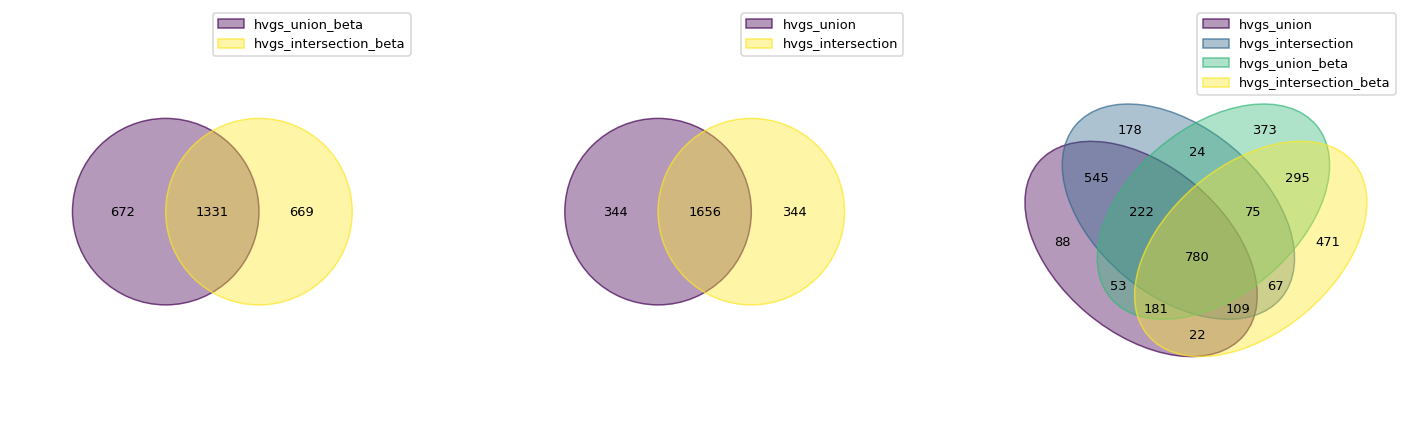

In [88]:
rcParams['figure.figsize']= (25,17)
fig,axs=plt.subplots(1,3)
hvgs = {
    "hvgs_union_beta": set(adata.var_names[adata.var.highly_variable_samples_target2000_beta]),
    "hvgs_intersection_beta":set(adata.var_names[adata.var.highly_variable_2000_beta]),
}
venn(hvgs,ax=axs[0])
hvgs = {
    "hvgs_union": set(adata.var_names[adata.var.highly_variable_samples_target2000]),
    "hvgs_intersection":set(adata.var_names[adata.var.highly_variable]),
}
venn(hvgs,ax=axs[1])
hvgs = {
    "hvgs_union": set(adata.var_names[adata.var.highly_variable_samples_target2000]),
    "hvgs_intersection":set(adata.var_names[adata.var.highly_variable]),
    "hvgs_union_beta": set(adata.var_names[adata.var.highly_variable_samples_target2000_beta]),
    "hvgs_intersection_beta":set(adata.var_names[adata.var.highly_variable_2000_beta]),
}
venn(hvgs,ax=axs[2])

<AxesSubplot:>

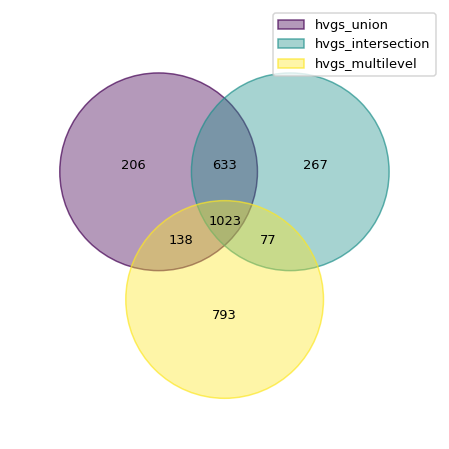

In [124]:
rcParams['figure.figsize']= (8,8)
fig,ax=plt.subplots()
hvgs = {
    "hvgs_union": set(adata.var_names[adata.var.highly_variable_samples_target2000]),
    "hvgs_intersection":set(adata.var_names[adata.var.highly_variable]),
    "hvgs_multilevel":set(adata.var_names[adata.var.highly_variable_multilevel_target2000]),
}
venn(hvgs,ax=ax)

#C: Selecting HVGs at multiple levels has large effect on HVG composition.

<AxesSubplot:>

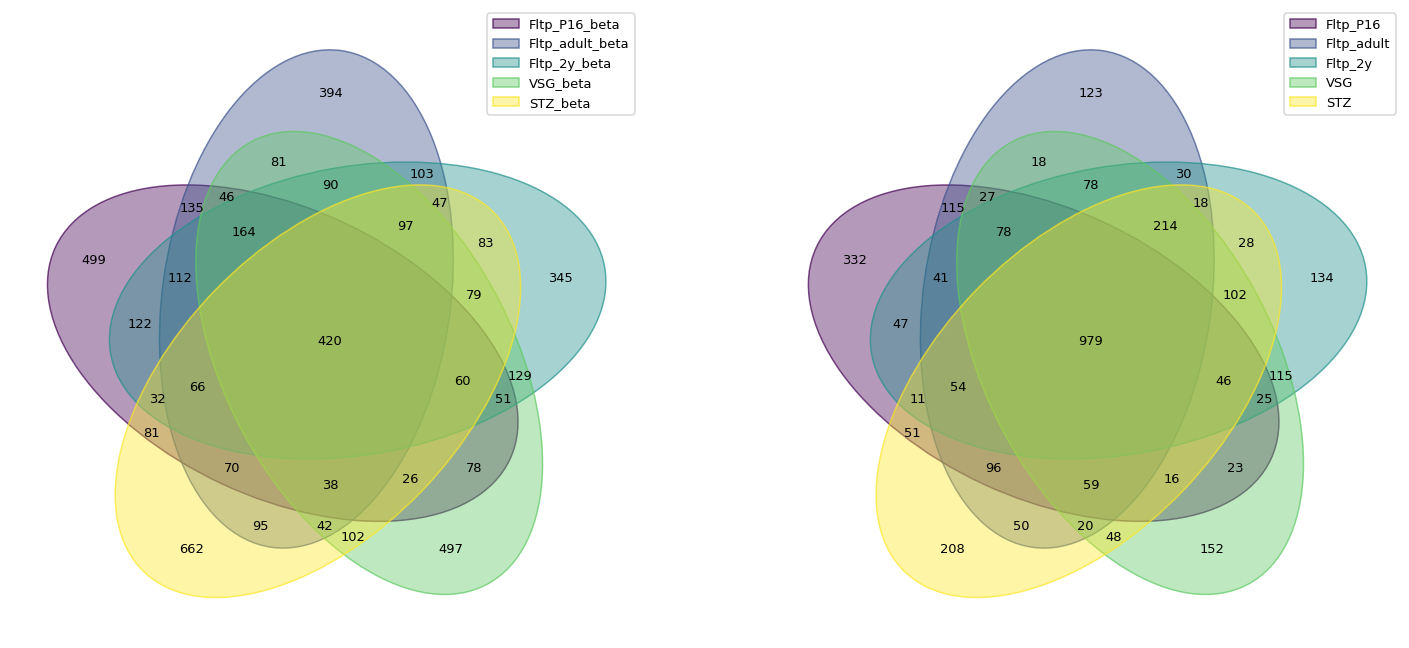

In [125]:
# HVGs per study
rcParams['figure.figsize']= (25,17)
fig,axs=plt.subplots(1,2)
hvgs = {}
for study in adata.obs.study.unique():
    hvgs[study+'_beta']=set(adata.var_names[adata.var['highly_variable_2000_beta_'+study]])
venn(hvgs,ax=axs[0])
hvgs = {}
for study in adata.obs.study.unique():
    hvgs[study]=set(adata.var_names[adata.var['highly_variable_2000_'+study]])
venn(hvgs,ax=axs[1])

#C: Beta HVGs are more diverse across studies. This is probably due to cell-type HVGs being conserved across studies due to presence of similar cell types, while beta cell HVGs depend on biological perturbation present in each study.

Ratio overlap (based on smaller HVG set) between HVG sets

In [135]:
# Compute HVG set overlap as ratio of smaller HVG set size
hvg_endings=['2000','samples_target2000','multilevel_target2000','5000','2000_beta','samples_target2000_beta']
overlap=pd.DataFrame(index=hvg_endings,columns=hvg_endings)
hvgs=adata.var.rename({'highly_variable':'highly_variable_2000'},axis=1)
for i in range(len(hvg_endings)-1):
    for j in range(i+1,len(hvg_endings)):
        hvg_col1='highly_variable_'+hvg_endings[i]
        hvg_col2='highly_variable_'+hvg_endings[j]
        hvgs1=set(hvgs.index[hvgs[hvg_col1]])
        hvgs2=set(hvgs.index[hvgs[hvg_col2]])
        overlap.loc[hvg_endings[i],hvg_endings[j]]=len(hvgs1&hvgs2)/min([len(hvgs1),len(hvgs2)])

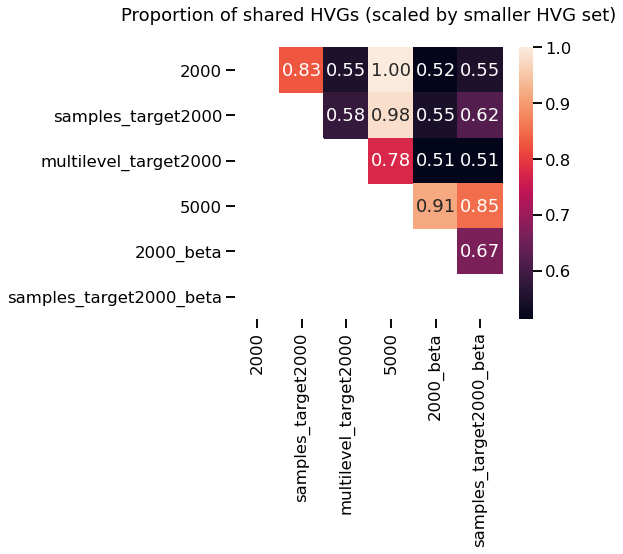

In [153]:
# Plot HVG overlap ratio
rcParams['figure.figsize']= (6,5)
mask = np.zeros_like(overlap.values)
mask[np.tril_indices_from(mask)] = True
sb.heatmap(overlap.fillna(0),mask=mask,annot=True, fmt=".2f")
t=plt.title('Proportion of shared HVGs (scaled by smaller HVG set)\n')

#C: Increasing HVG set (5000 HVGs) does not cover multilevel HVGs (it cover union/intersection HVGs). It covers beta HVGs better than multilevel HVGs, possibly indicating bias of HVGs towards beta cells. 

Presence of beta subtype markers (known to vary across beta cells) in different HVG sets

Ins1 not in var_names
Ins2 not in var_names
Pyy not in var_names
Chga not in var_names


<AxesSubplot:>

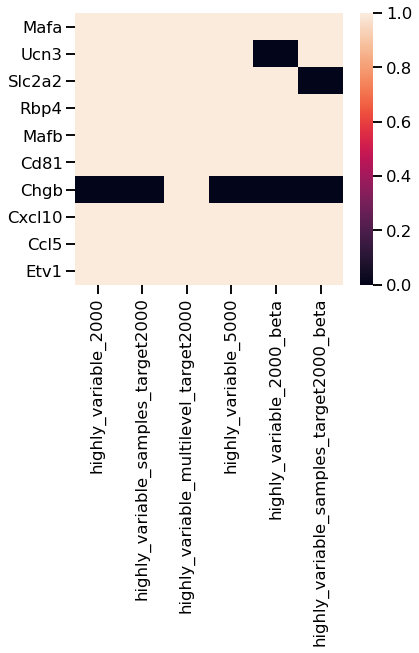

In [173]:
# beta subtype markers
beta_subtype_markers=['Ins1','Ins2','Mafa','Ucn3','Slc2a2','Rbp4','Mafb','Pyy','Cd81','Chgb','Chga',
                      'Cxcl10','Ccl5','Etv1']
# Check if marker is in var_names and if so if it is in HVG sets
marker_hvg=pd.DataFrame(columns=['highly_variable_'+hvg_ending for hvg_ending in hvg_endings])
for marker in beta_subtype_markers:
    if marker not in adata.var_names:
        print(marker,'not in var_names')
    else:
        marker_hvg.loc[marker,:]=hvgs.loc[marker,marker_hvg.columns].values
# Plot marker presence in HVG sets
marker_hvg=marker_hvg.replace({False:0,True:1})
sb.heatmap(marker_hvg)

#C: It is odd that Chgb is not present in beta HVGs as it varies across and within some of the samples in beta cells. It is also unexpected that some other beta cell subtype markers are missing only from beta HVGs. This might be due to them being even more lowly/highly expressed in non-beta populations, thus being marked as HVG only when other cells are included.

Presence of beta markers in per study beta cell based HVGs.

Ins1 not in var_names
Ins2 not in var_names
Pyy not in var_names
Chga not in var_names


<AxesSubplot:>

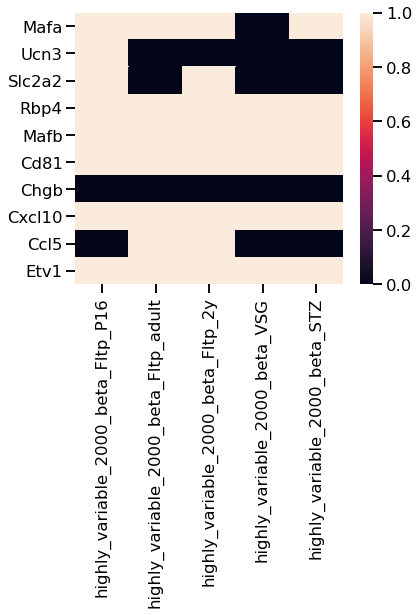

In [174]:
# beta subtype markers
beta_subtype_markers=['Ins1','Ins2','Mafa','Ucn3','Slc2a2','Rbp4','Mafb','Pyy','Cd81','Chgb','Chga',
                      'Cxcl10','Ccl5','Etv1']
# Check if marker is in var_names and if so if it is in HVG sets
marker_hvg=pd.DataFrame(columns=['highly_variable_2000_beta_'+study for study in adata.obs.study.unique()])
for marker in beta_subtype_markers:
    if marker not in adata.var_names:
        print(marker,'not in var_names')
    else:
        marker_hvg.loc[marker,:]=hvgs.loc[marker,marker_hvg.columns].values
# Plot marker presence in HVG sets
marker_hvg=marker_hvg.replace({False:0,True:1})
sb.heatmap(marker_hvg)

## Visualisation

In [5]:
# Sort age categories
sorted_age=['16 d','3 m','182 d','20 w','2 y']
# Make sure that all categories were used for sorting
if set(sorted_age)==set(list(adata.obs.age.unique())):
    adata.obs['age']= pd.Categorical(adata.obs.age,sorted_age)

#### Unscaled data

In [115]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')

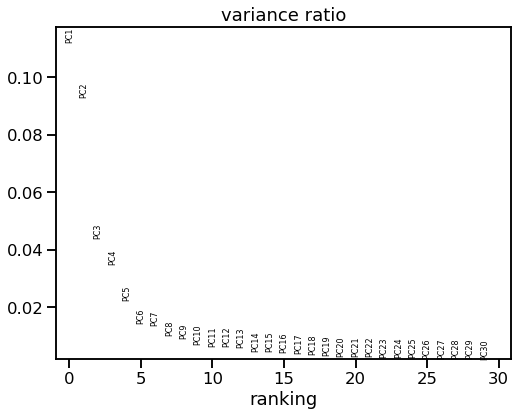

In [116]:
rcParams['figure.figsize']= (8,6)
sc.pl.pca_variance_ratio(adata)

In [117]:
# Select number of PCs to use
N_PCS=13

In [118]:
sc.pp.neighbors(adata,n_pcs = N_PCS) 
sc.tl.umap(adata)

Cheeck if np.nan values are present in metadata that would not be plotted:

In [119]:
# Check if metadata contains nan values that would not be plotted
for col in ['study','file','sex','age','phase_cyclone','tissue','cell_type']:
    n_na=adata.obs[col].isna().sum()
    print(col,'N nan:',n_na)

study N nan: 0
file N nan: 0
sex N nan: 0
age N nan: 0
phase_cyclone N nan: 0
tissue N nan: 0
cell_type N nan: 0


In [120]:
adata

AnnData object with n_obs × n_vars = 73487 × 13651
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'doublet_score', 'size_factors_study', 'pre_cell_type', 'cell_type', 'cell_type_multiplet', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'x_score', 'y_score', 'sex', 'age', 'design', 'strain', 'tissue', 'technique', 'study', 'study_sample', 'size_factors_sample'
    var: 'n_cells-Fltp_2y', 'n_cells-Fltp_P16', 'n_cells-Fltp_adult', 'n_cells-STZ', 'n_cells-VSG', 'highly_variable', 'highly_variable_5000'
    uns: 'study_sample_colors', 'file_colors', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

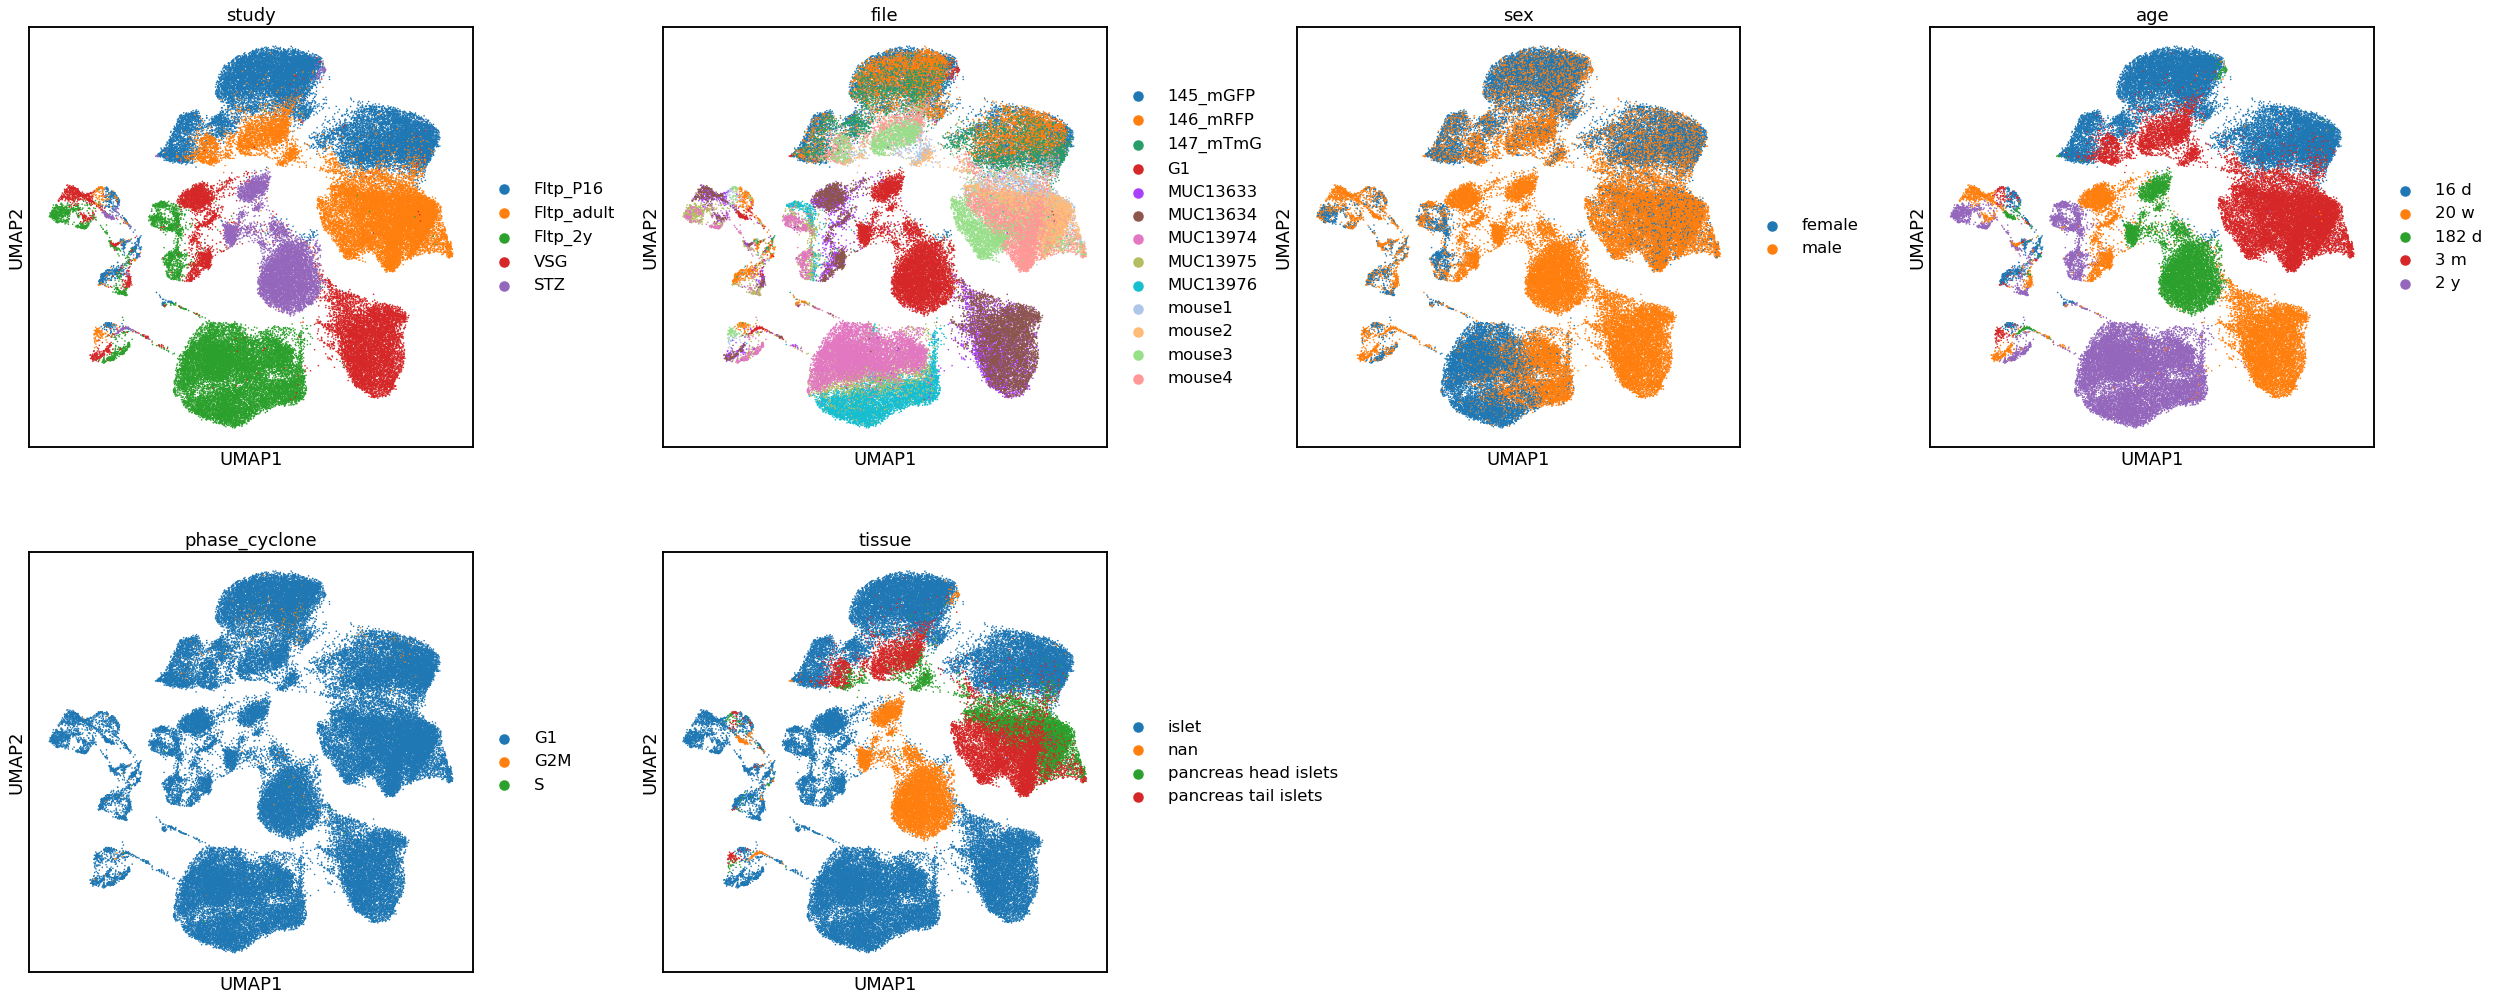

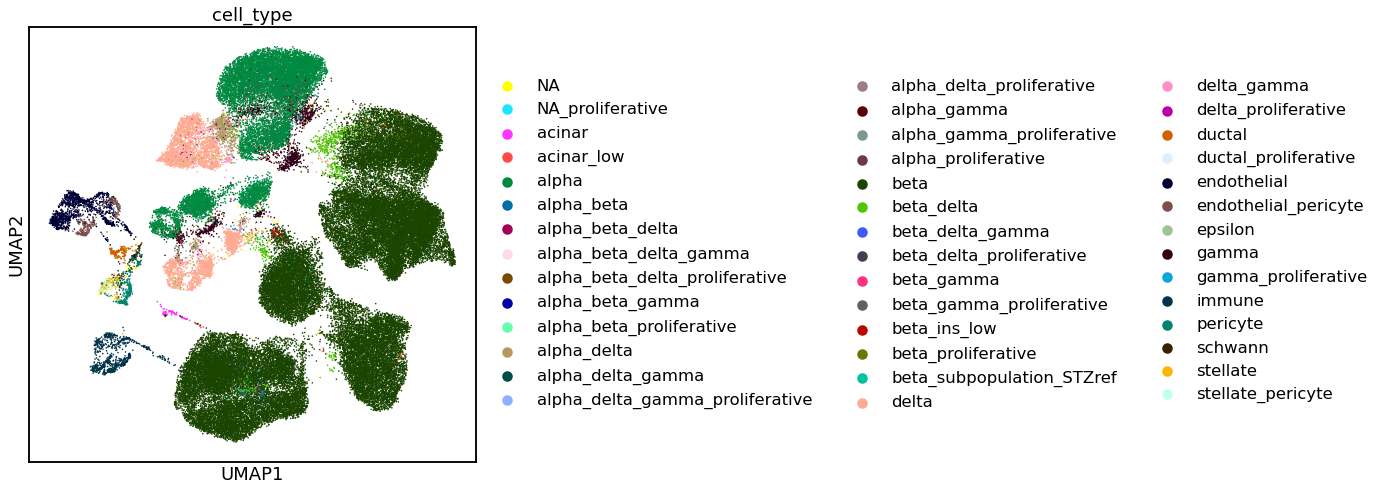

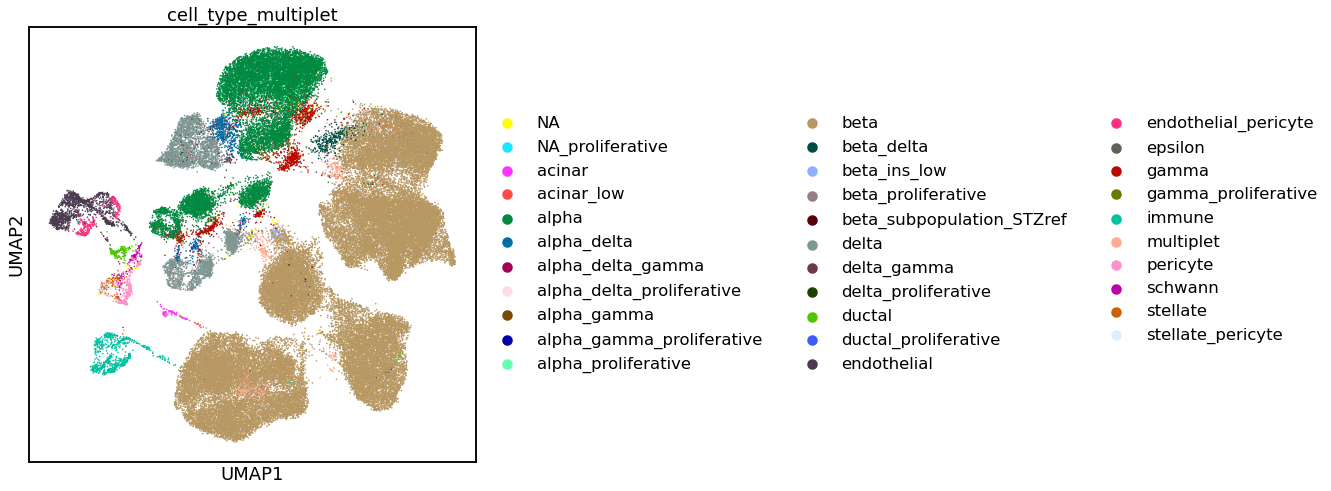

In [129]:
rcParams['figure.figsize']= (8,8)
sc.pl.umap(adata, color=['study','file','sex','age','phase_cyclone','tissue',] ,size=10, use_raw=False,wspace=0.3)
sc.pl.umap(adata, color=['cell_type'] ,size=10, use_raw=False,wspace=0.3)
sc.pl.umap(adata, color=['cell_type_multiplet'] ,size=10, use_raw=False,wspace=0.3)

In [133]:
adata.obs.cell_type_multiplet[adata.obs.cell_type_multiplet.str.contains('NA|multiplet')].unique()

[NA, multiplet, NA_proliferative]
Categories (3, object): [NA, multiplet, NA_proliferative]

#### Save normalised log scaled data with HVG annotation with UMAP

In [160]:
if SAVE:
    h.save_h5ad(adata=adata,file=shared_folder+'data_normalised.h5ad',unique_id2=UID2)

#### Z-scaled data

In [123]:
# Scale data and compute PCA
adata_scl=adata.copy()
sc.pp.scale(adata_scl,max_value=10)
sc.pp.pca(adata_scl, n_comps=30, use_highly_variable=True, svd_solver='arpack')

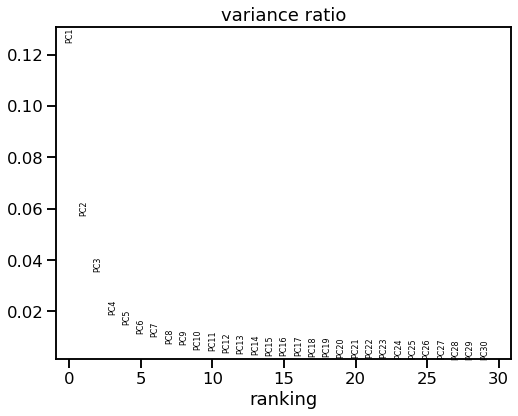

In [124]:
rcParams['figure.figsize']= (8,6)
sc.pl.pca_variance_ratio(adata_scl)

In [125]:
# Select number of PCs to use
N_PCS=13

In [126]:
sc.pp.neighbors(adata_scl,n_pcs = N_PCS) 
sc.tl.umap(adata_scl)

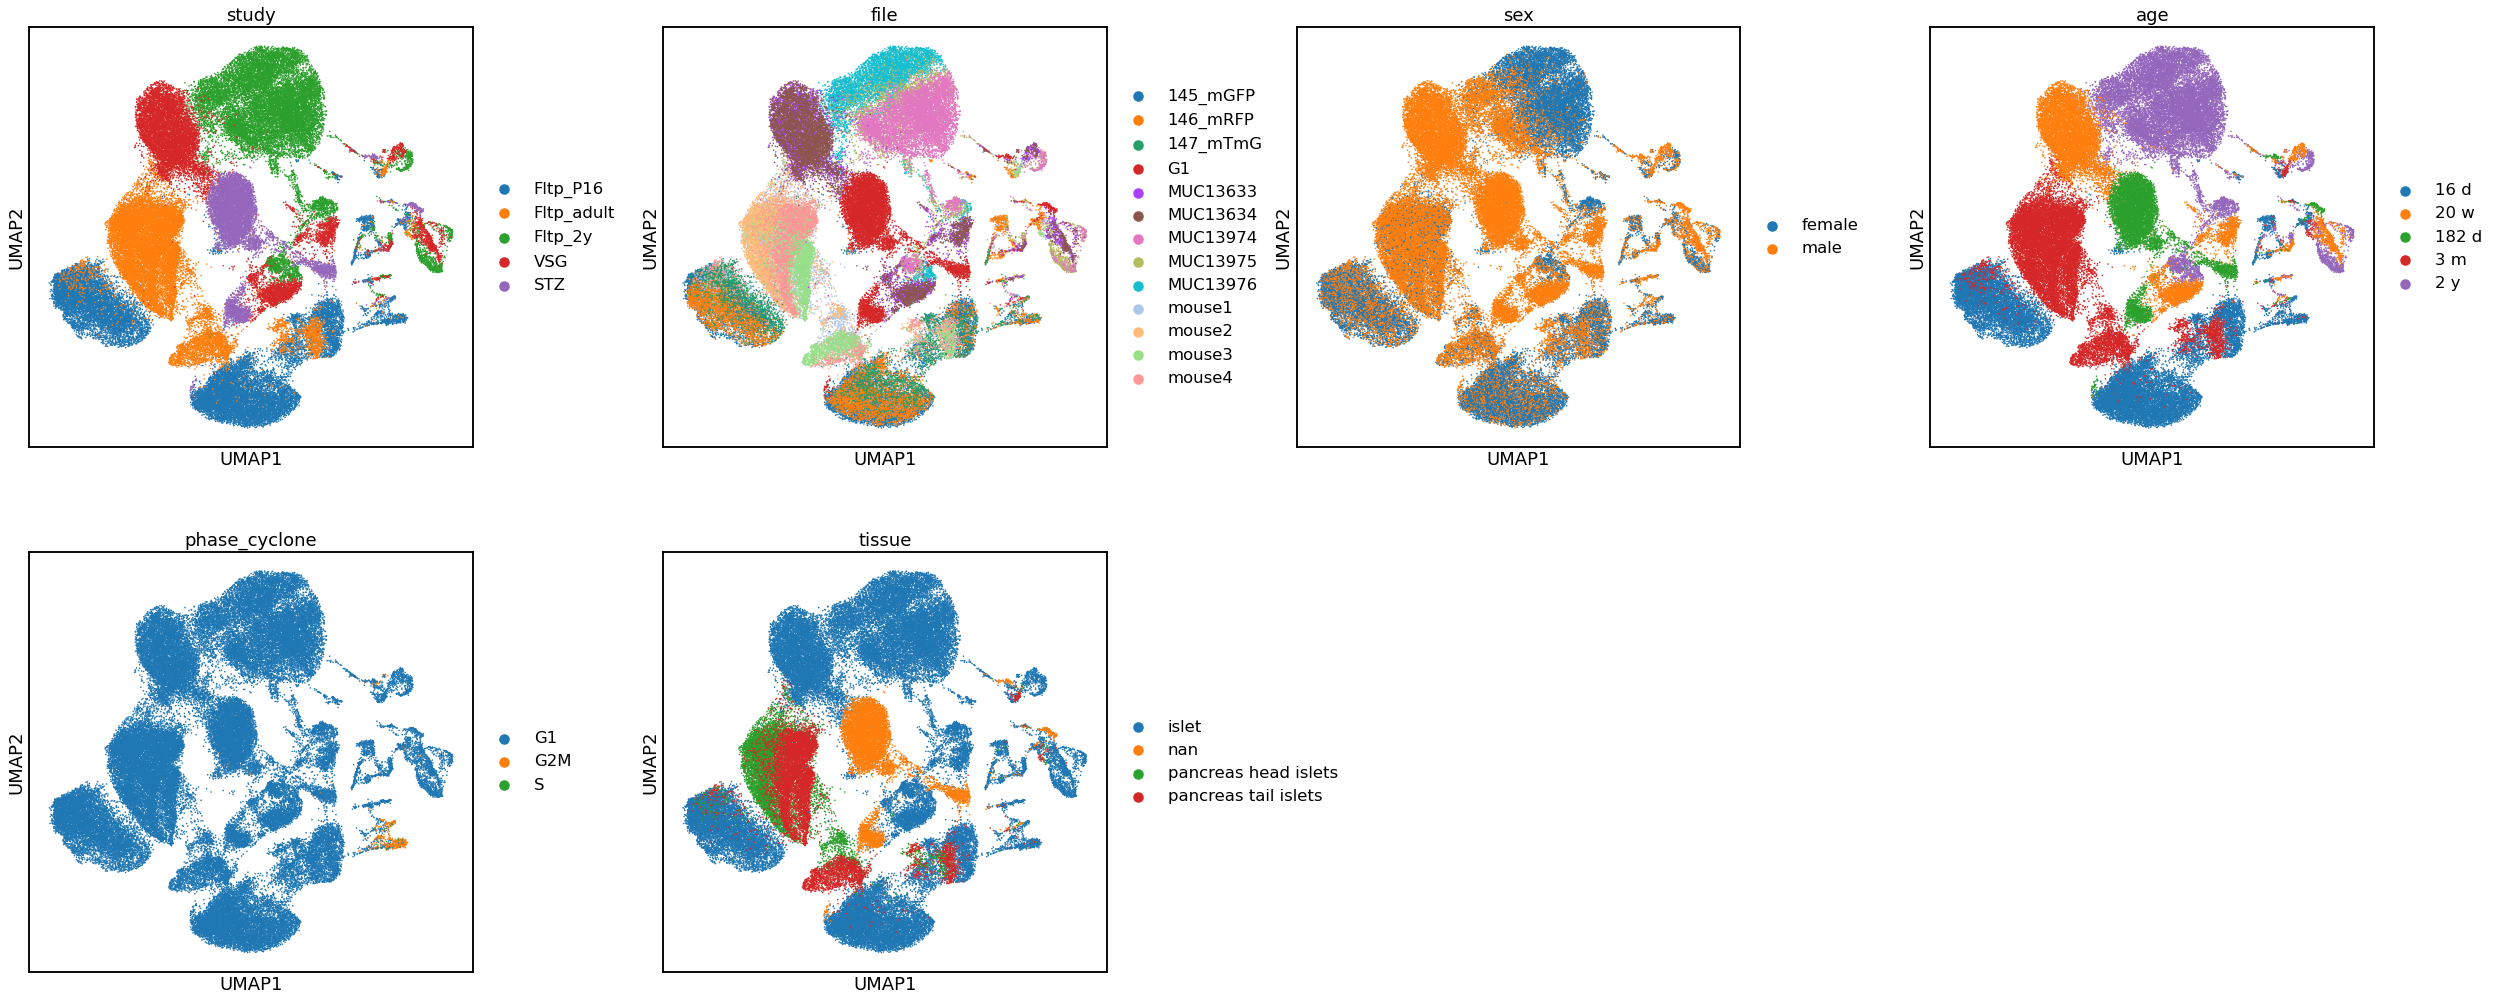

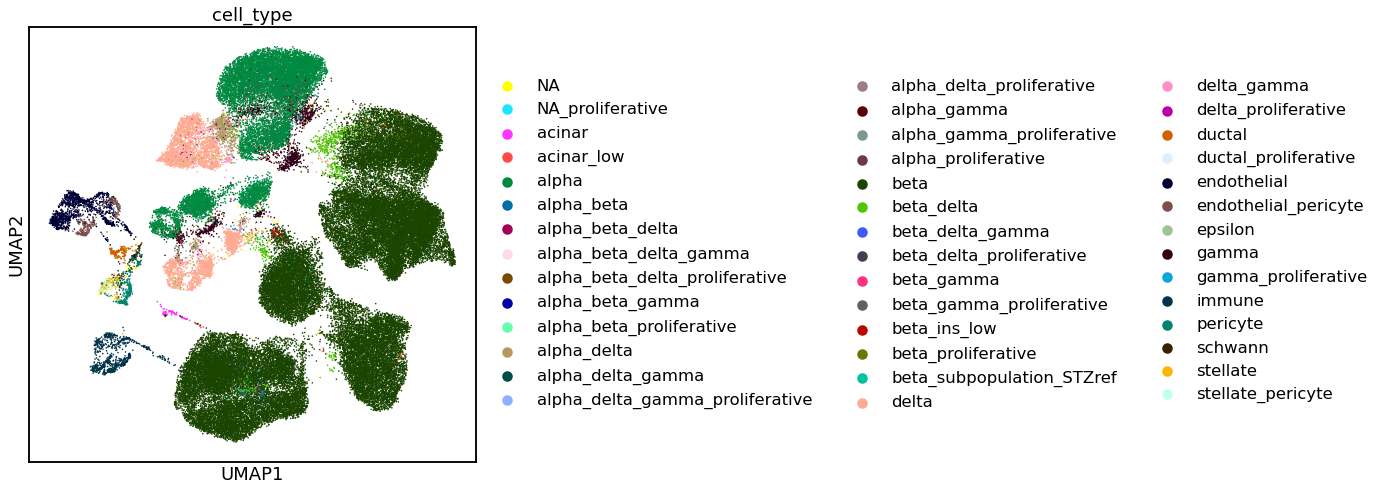

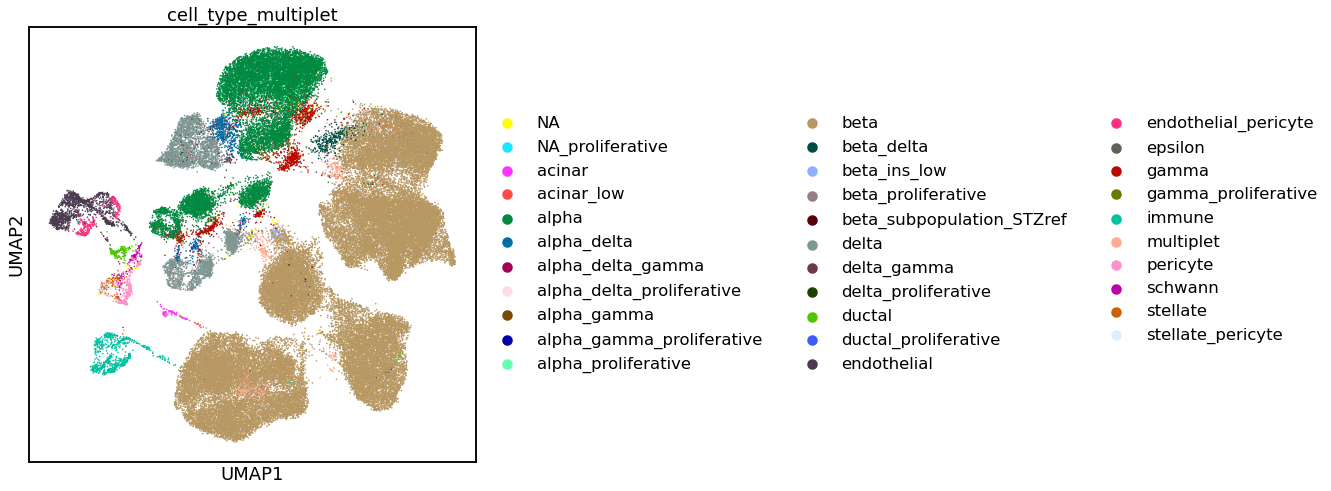

In [130]:
rcParams['figure.figsize']= (8,8)
sc.pl.umap(adata_scl, color=['study','file','sex','age','phase_cyclone','tissue'] ,size=10, use_raw=False,wspace=0.3)
sc.pl.umap(adata, color=['cell_type'] ,size=10, use_raw=False,wspace=0.3)
sc.pl.umap(adata, color=['cell_type_multiplet'] ,size=10, use_raw=False,wspace=0.3)

## Summary of metadata

In [6]:
adata=h.open_h5ad(file=shared_folder+'data_normalised.h5ad',unique_id2=UID2)
#adata=sc.read_h5ad(shared_folder+'data_normalised.h5ad')

N cells per study:

In [28]:
# N cells
print('N cells per sample')
adata.obs['study_sample'].value_counts()

N cells per sample


Fltp_P16_145_mGFP    9221
STZ_G1               7678
Fltp_2y_MUC13974     7534
Fltp_P16_146_mRFP    7172
Fltp_2y_MUC13976     6081
VSG_MUC13634         5728
VSG_MUC13633         5486
Fltp_adult_mouse4    5359
Fltp_adult_mouse2    4664
Fltp_adult_mouse1    4094
Fltp_2y_MUC13975     3746
Fltp_P16_147_mTmG    3488
Fltp_adult_mouse3    3236
Name: study_sample, dtype: int64

In [29]:
sample_count_df=pd.DataFrame(adata.obs['study_sample'].value_counts())
sample_count_df.columns=['n_cells']
sample_count_df['study_sample']=sample_count_df.index
sample_count_df['study']=[adata.obs.query('study_sample == @sample')['study'][0] for sample in sample_count_df.index]
sample_count_df['sample']=[adata.obs.query('study_sample == @sample')['file'][0] for sample in sample_count_df.index]

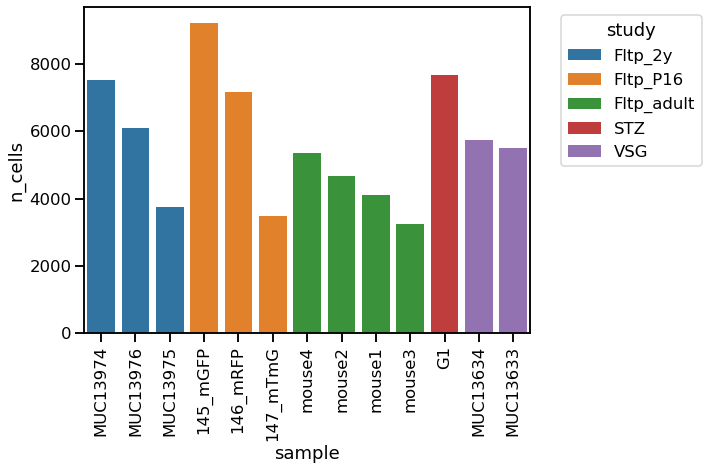

In [30]:
rcParams['figure.figsize']= (8,6)
sb.barplot(x="sample", y="n_cells", hue="study", data=sample_count_df.sort_values('study'),dodge=False)
a=plt.xticks(rotation=90)
plt.legend( title='study', bbox_to_anchor=(1.05, 1), loc='upper left')

Sex distribution:

In [ ]:
print('N male/female per sample')
adata.obs.groupby(['study_sample','sex']).size().unstack(fill_value=0)

In [18]:
print('\nMedian cell type counts across samples')
median_type_n=adata.obs.groupby(['study_sample','cell_type']).size().unstack(fill_value=0).median().sort_values(ascending=False)
median_type_n


Median cell type counts across samples


cell_type
beta                               3656.0
alpha                               654.0
delta                               268.0
immune                               60.0
gamma                                58.0
beta_delta                           53.0
endothelial                          49.0
alpha_delta                          28.0
alpha_gamma                          18.0
endothelial_pericyte                 13.0
delta_gamma                          12.0
NA                                    6.0
pericyte                              4.0
ductal                                3.0
beta_proliferative                    3.0
alpha_beta_delta                      2.0
schwann                               2.0
alpha_delta_gamma                     2.0
acinar_low                            0.0
alpha_delta_gamma_proliferative       0.0
acinar                                0.0
alpha_beta                            0.0
alpha_beta_delta_gamma                0.0
alpha_beta_delta_prolife

In [17]:
# Find cells with good/bad annotation
eval_cells=~adata.obs.cell_type_multiplet.str.contains('NA|multiplet')
eval_cells.replace({True:'yes',False:'no'},inplace=True)
adata.obs['true_type']=eval_cells

In [19]:
anno_counts=pd.DataFrame(adata.obs.groupby(['study','true_type','cell_type']).size())
anno_counts.columns=['n_cells']
anno_counts.reset_index(inplace=True)

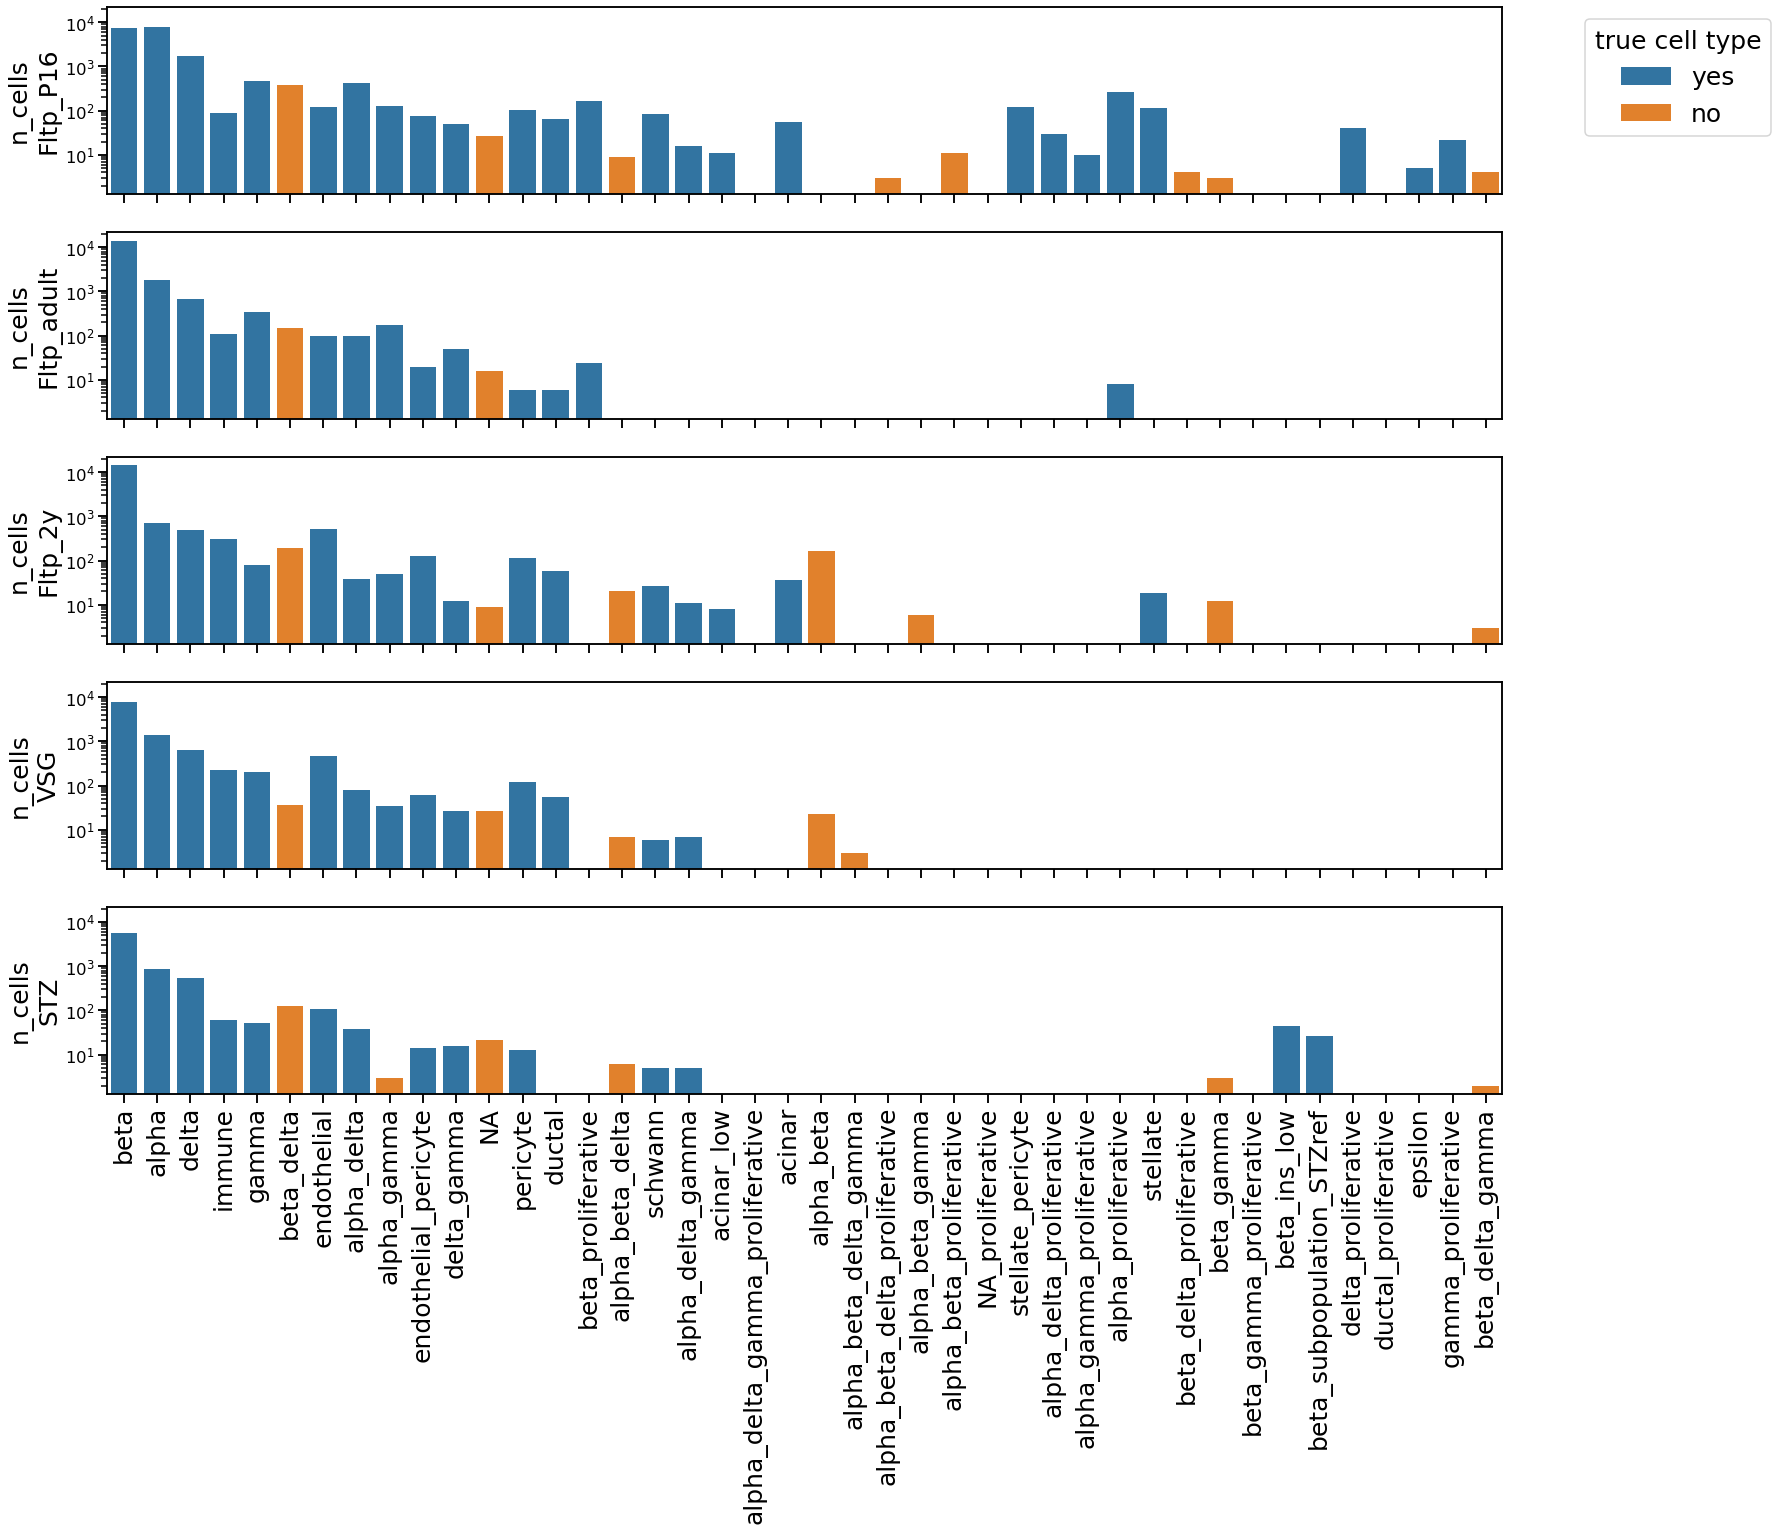

In [20]:
rcParams['figure.figsize']= (25,20)
fix,axs=plt.subplots(5,1,sharex=True,sharey=True)
plt.xticks(fontsize= 25)
for i,study in enumerate(adata.obs.study.unique()):
    anno_counts_sub=anno_counts.query('study ==@study')
    sb.barplot(x="cell_type", y="n_cells", hue="true_type", 
               data=anno_counts_sub,dodge=False, ax=axs[i],
               # Sort by median cell type count across studies
               order=median_type_n.index.values,hue_order=['yes','no'])
    a=plt.xticks(rotation=90)
    plt.yscale('log')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('n_cells\n'+study,fontsize=25)
    if i>0:
        axs[i].get_legend().remove()
    else:
        l=axs[i].legend( title='true cell type', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=25)
        l.get_title().set_fontsize(25)

In [36]:
print('Cell type counts per sample')
pd.set_option('display.max_columns', len(adata.obs.cell_type.unique()))
display(adata.obs.groupby(['study_sample','cell_type']).size().unstack(fill_value=0))

Cell type counts per sample


cell_type          NA  NA_proliferative  acinar  acinar_low  alpha  \
study_sample                                                         
Fltp_2y_MUC13974    2                 0      18           6    234   
Fltp_2y_MUC13975    6                 0      18           2    169   
Fltp_2y_MUC13976    1                 0       0           0    306   
Fltp_P16_145_mGFP  11                 0       0           0   4065   
Fltp_P16_146_mRFP  12                 1      52          11   2858   
Fltp_P16_147_mTmG   4                 0       3           0    905   
Fltp_adult_mouse1  13                 0       0           0    164   
Fltp_adult_mouse2   0                 0       0           0     87   
Fltp_adult_mouse3   3                 0       0           0    952   
Fltp_adult_mouse4   0                 0       0           0    625   
STZ_G1             22                 0       0           0    872   
VSG_MUC13633       12                 0       0           0    716   
VSG_MUC13634       14                 0       0           0    654   

cell_type          alpha_beta  alpha_beta_delta  alpha_beta_delta_gamma  \
study_sample                                                              
Fltp_2y_MUC13974           71                 9                       0   
Fltp_2y_MUC13975           38                 9                       1   
Fltp_2y_MUC13976           57                 3                       0   
Fltp_P16_145_mGFP           0                 1                       0   
Fltp_P16_146_mRFP           0                 1                       0   
Fltp_P16_147_mTmG           0                 7                       0   
Fltp_adult_mouse1           0                 0                       0   
Fltp_adult_mouse2           0                 0                       0   
Fltp_adult_mouse3           0                 0                       0   
Fltp_adult_mouse4           0                 0                       0   
STZ_G1                      0                 6                       0   
VSG_MUC13633               14                 5                       3   
VSG_MUC13634                9                 2                       0   

cell_type          alpha_beta_delta_proliferative  alpha_beta_gamma  \
study_sample                                                          
Fltp_2y_MUC13974                                0                 1   
Fltp_2y_MUC13975                                0                 1   
Fltp_2y_MUC13976                                0                 4   
Fltp_P16_145_mGFP                               0                 0   
Fltp_P16_146_mRFP                               0                 0   
Fltp_P16_147_mTmG                               3                 0   
Fltp_adult_mouse1                               0                 0   
Fltp_adult_mouse2                               0                 0   
Fltp_adult_mouse3                               0                 0   
Fltp_adult_mouse4                               0                 0   
STZ_G1                                          0                 0   
VSG_MUC13633                                    0                 0   
VSG_MUC13634                                    0                 0   

cell_type          alpha_beta_proliferative  alpha_delta  alpha_delta_gamma  \
study_sample                                                                  
Fltp_2y_MUC13974                          0           10                  2   
Fltp_2y_MUC13975                          0           21                  8   
Fltp_2y_MUC13976                          0            7                  1   
Fltp_P16_145_mGFP                         4          214                  6   
Fltp_P16_146_mRFP                         6           35                  1   
Fltp_P16_147_mTmG                         1          169                  9   
Fltp_adult_mouse1                         0            9                  0   
Fltp_adult_mouse2                         0   

#### Beta cells

In [7]:
excluded_beta=['beta_delta']
selected_beta=[ct for ct in adata.obs.cell_type_multiplet.unique() if 'beta' in ct and ct not in excluded_beta]
selected_beta

['beta', 'beta_proliferative', 'beta_subpopulation_STZref', 'beta_ins_low']

In [9]:
# Subset adata to beta cells
adata_beta=adata[adata.obs.cell_type.isin(selected_beta),:].copy()
anno_counts_beta=pd.DataFrame(adata_beta.obs.groupby(['study','true_type','cell_subtype']).size())
anno_counts_beta.columns=['n_cells']
anno_counts_beta.reset_index(inplace=True)

Cell proportions for beta cells only

In [11]:
print('\nMedian beta cell subtype counts across samples')
median_type_n_beta=adata_beta.obs.groupby(['study_sample','cell_subtype']).size().unstack(fill_value=0).median().sort_values(ascending=False)
median_type_n_beta


Median beta cell subtype counts across samples


cell_subtype
beta                                         1427.0
beta_Cd81_high                                298.0
beta_Cxcl10_high                               74.0
beta_immature                                  39.0
beta_Cd81_high_Cxcl10_high                     20.0
beta_Ccl5_high                                  3.0
beta_proliferative                              3.0
beta_immature_ins_low                           2.0
beta_Cd81_high_Ccl5_high                        2.0
beta_Cd81_high_Chga_Chgb_high                   0.0
beta_Cd81_high_Chgb_high                        0.0
beta_Chga_Chgb_high                             0.0
beta_Cd81_high_Cxcl10_high_Chga_Chgb_high       0.0
beta_Cd81_high_Cxcl10_high_Chgb_high            0.0
beta_Cd81_high_Etv1_high                        0.0
beta_Cd81_high_Etv1_high_Chgb_high              0.0
beta_Cd81_high_ins_low                          0.0
beta_Cd81_high_Cxcl10_high_Ccl5_high            0.0
beta_subpopulation_STZref                       0.0

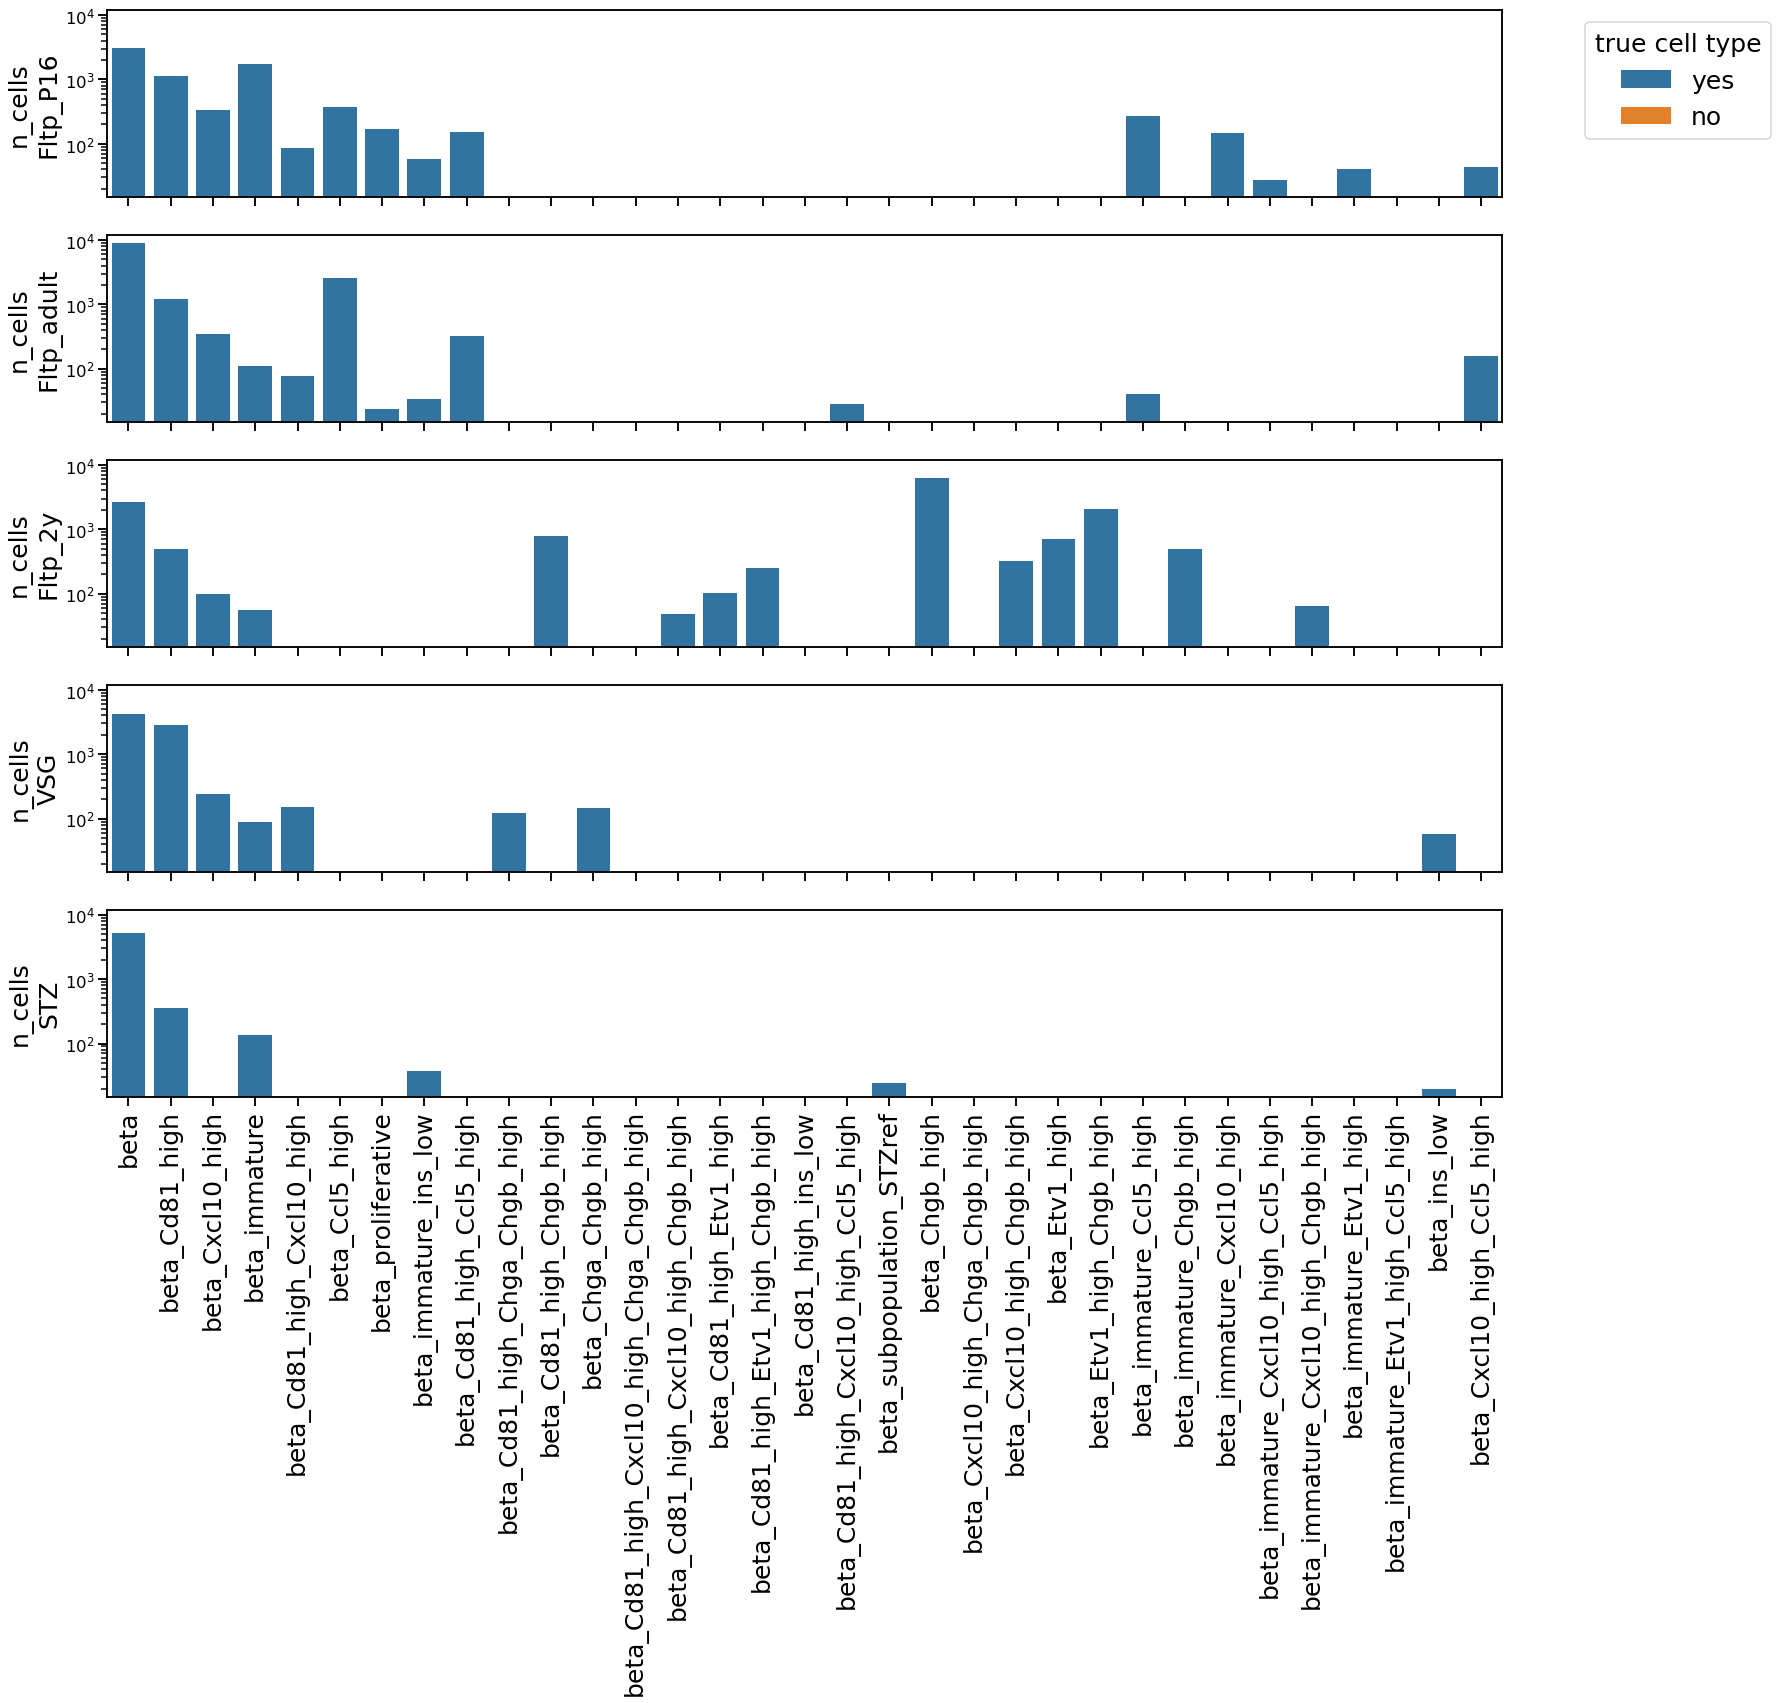

In [22]:
rcParams['figure.figsize']= (25,20)
fix,axs=plt.subplots(5,1,sharex=True,sharey=True)
plt.xticks(fontsize= 25)
for i,study in enumerate(adata_beta.obs.study.unique()):
    anno_counts_sub=anno_counts_beta.query('study ==@study')
    sb.barplot(x="cell_subtype", y="n_cells", hue="true_type", 
               data=anno_counts_sub,dodge=False, ax=axs[i],
               # Sort by median cell type count across studies
               order=median_type_n_beta.index.values,hue_order=['yes','no'])
    a=plt.xticks(rotation=90)
    plt.yscale('log')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('n_cells\n'+study,fontsize=25)
    if i>0:
        axs[i].get_legend().remove()
    else:
        l=axs[i].legend( title='true cell type', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=25)
        l.get_title().set_fontsize(25)